In [6]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
from RandomMatrixTheory import goe

import importlib as imp
def reload_modules():
    imp.reload(cost)
    imp.reload(fig_help)

import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
latex_engine = 'xelatex'
latex_elements = {'preamble':r'\usepackage{physics}'}

%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:200])
colors_ls_cyc = itertools.cycle(colors_ls)

markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

base_dir = "../results/"


/Users/rafal.swietek/Projects/QHamSolver/QuantumSun/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/


In [3]:
def order_of_magnitude2(a_value):
    #return 2
    if np.abs(a_value) < 1.0 and a_value != 0:
        m = np.abs(np.log10(np.abs(a_value)))
        return int(max(math.ceil(m) + 1., 2.))
    else: 
        return 2

def order_of_magnitude(a_value):
    a_value = np.round(a_value, 12)
    num_str = f"{a_value - int(a_value)}"
    num_str = num_str[2:]
    _size = len(num_str)
    if num_str == "0":
        _size = 0;
    
    return _size
    
def info_raw(L, N, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False):
    arr = [J, gamma, zeta, alfa, h, w] if alfa < 1.0 else [J, gamma, alfa, h, w]
    names = ['J', 'g', 'zeta', 'alfa', 'h', 'w'] if alfa < 1.0 else ['J', 'g', 'alfa', 'h', 'w']
    info = "_L=%d,N=%d"%(L,N)
    for i, var in enumerate(arr):
        n = order_of_magnitude2(var) if use_old else order_of_magnitude(var)
        info += str(",%s={:.%df}"%(names[i], n)).format(round(var, n))
    if ini_ave: info += ",ini_ave"
    return info

def info(L, N, J, gamma, zeta, alfa, h, w, ini_ave = 0, use_old = False, ext = '.dat'):
    return info_raw(L, N, J, gamma, zeta, alfa, h, w, ini_ave, use_old) + ext


def GOE(x : np.array):
    """
    GOE shape of sff in thermodynamic limit
    
    Parameters:
    -----------------
        x : np.array
            numpy array with datapoints (times defined for unfolded data)
    """
    return np.array([2 * a - a * np.log(1 + 2 * a) if a < 1 else 2 - a * np.log( (2 * a + 1) / (2 * a - 1) ) for a in x])

def remove_fluctuations(data, bucket_size=10):
    new_data = data;
    half_bucket = int(bucket_size / 2)
    for k in range(half_bucket, len(data) - half_bucket):
        average = np.sum(data[k - half_bucket : k + half_bucket])
        new_data[k - half_bucket] = average / bucket_size
    return new_data

dir_E = base_dir + 'DIAGONALIZATION/'


def page(L_a, L_b):
    d_a = 2**L_a
    d_b = 2**L_b
    return digamma(d_a * d_b + 1) - digamma(max(d_a, d_b) + 1) - (min(d_a, d_b) - 1) / (2 * max(d_a, d_b))

[ 1  3  5  6  9 34 44 52 68]
[ 3  9  5  6  9 34  9  3  5  6  9  3  5  9 44 52  3  6  6  6  9  3  6  6
 34]


# SPECTRAL FORM FACTOR

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


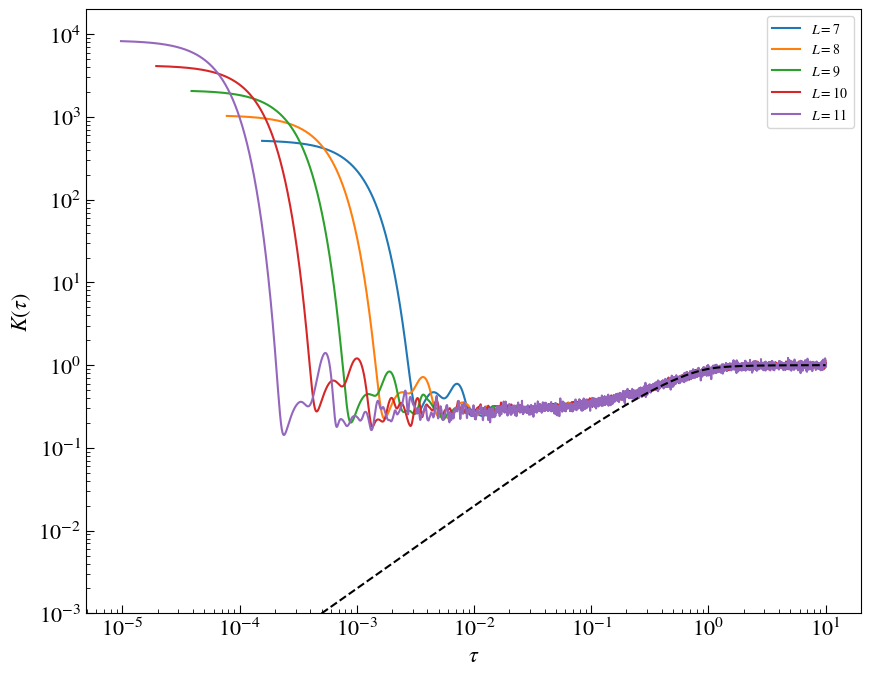

In [23]:
L=11
J=1.0
alfa=0.75
h=1.0
w=0.5
zeta=0.2
N=3
gamma=1.0
ini_ave=1

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(10,8), dpi = 100)

FOLDED = False

alfa_vals = np.linspace(0.63, 0.78, 16)
w_vals = np.linspace(2.0, 14.5, 26)
w_vals = np.linspace(2.0, 20.0, 37)
print(w_vals)
sizes = np.arange(7, 12, 1)
times = [1]
for L in sizes:
#for alfa in alfa_vals:
#for w in w_vals:
    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, N, J, gamma, zeta, alfa, h, w, ini_ave)
    #if not exists(filename):
    #    filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, M, J, gamma, zeta, alfa, h, w, ini_ave, use_old=True)
    if exists(filename):
        data = pd.read_table(filename, sep="\t", header=None)
        times = np.array(data[0])
        sff = np.array(data[1])
        #sff = remove_fluctuations(sff, int(0.005 * len(sff)))
        tH = data[2][0]
        gap_ratio = data[4][0]
        axis.plot(times, sff, lw=1.5, label=r"$L=%d$"%L)
    else:
        print(filename)

axis.plot(times, GOE(times), ls='--', color='black')
#axis.axhline(y=0.38, ls=':', lw=2, color='black')
axis.legend()
axis.set_ylim(1e-3, 2e4)
axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylabel(r"$K(\tau)$", fontsize=16)
axis.set_xlabel(r"$\tau$", fontsize=16)
axis.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
axis.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
#axis.set_ylim(0, 1.1)

In [19]:
epsilon=8e-2

def get_points(L, gamma):
    w_L = []
    tau_L = []
    tH_L = []
    gaps_L = []
    for alfa in alfa_vals:
    # w_vals = np.linspace(2.0, 20.0, 37)
    # for w in w_vals:
    
        filename = base_dir + "SpectralFormFactor/" + ("folded" if FOLDED else "") + info(L, N, J, gamma, zeta, alfa, h, w, ini_ave)
        if exists(filename):
            w_L.append(alfa)
            data = pd.read_table(filename, sep="\t", header=None)
            times = np.array(data[0])
            sff = np.array(data[1])
            sff = remove_fluctuations(sff, int(0.01 * len(sff)))
            tH = data[2][0]
            gap_ratio = data[4][0]
            times_for_algorithm = times / tH if FOLDED else times
            sff_dev = np.abs(np.log10(sff / GOE(times_for_algorithm)))
            tau = np.nan
            for i, K in reversed(list(enumerate(sff_dev))):
                if K > epsilon and times[i] < (3 * tH if FOLDED else 3):
                    tau = times[i-1]
                    break
            tau_L.append(tau)
            tH_L.append(tH)
            gaps_L.append(gap_ratio)
            
        else:
            print(filename)
    
    return np.array(w_L), np.array(gaps_L), np.array(tau_L), np.array(tH_L)

[ 2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5
  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5
 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]


No handles with labels found to put in legend.


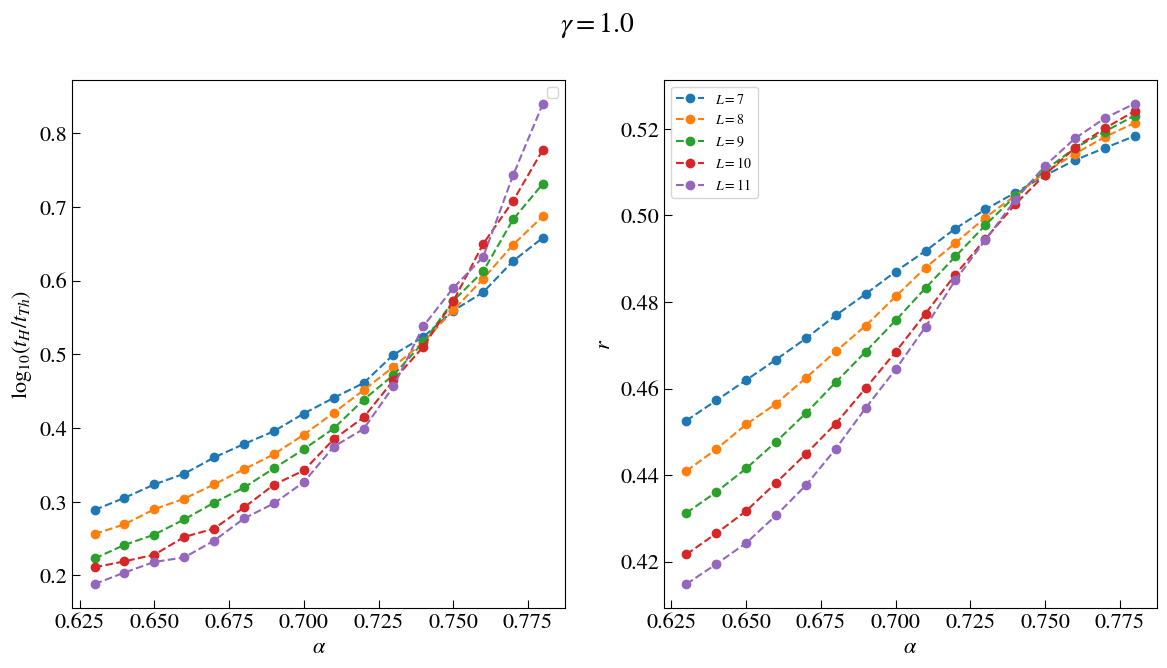

In [24]:
reload_modules()

FOLDED = False
L=11
J=1.0
alfa=1.00
h=1.0
w=0.5
zeta=0.2
N=3
gamma=2.0
ini_ave=1

COLLAPSE = 0
gamma_vals = np.linspace(1.0, 4.0, 13)
gamma_vals = [1.0]
for gamma in gamma_vals:
    fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(14,7), dpi = 100)

    taus = []
    gaps = []
    heisenberg_time = []
    times = [1]
    #w_vals = np.linspace(0.2, 4.0, 20)
    print(w_vals)
    sizes = np.arange(7,12)
    w_plot = []
    for L in sizes:
        w_L, gaps_L, tau_L, tH_L = get_points(L, gamma)

        w_plot.append(np.array(w_L))

        taus.append(np.array(tau_L))
        heisenberg_time.append(np.array(tH_L))
        gaps.append(gaps_L)
        

    gaps = np.array(gaps)
    taus = np.array(taus)
    w_plot = np.array(w_plot)

    if COLLAPSE:
        idx = 0
        xdata = [wx[idx:] for wx in w_plot]
        ydata = [r[idx:] for r in gaps]
        par1, crit_pars1, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par1, crit_pars1)

        #ydata = [tTh[idx:] for tTh in np.log10(1.0 / taus)]
        par2, crit_pars2, costfun, status = cost.get_crit_points(x=np.array(xdata), y=np.array(ydata), vals=sizes, crit_fun='lin', scaling_ansatz='KT', seed=412438923)
        print(par2, crit_pars2)

        rescale_fun = cost.resc_functions_dict['KT']
        critical_fun = cost.crit_functions_dict['lin']
        xlab = cost.scale_ansatz_label['KT']('W')
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(rescale_fun(w_plot[ii], L, critical_fun, par1, *crit_pars1), g_cond, ls='--', marker='o')
            axis[1].plot(rescale_fun(w_plot[ii], L, critical_fun, par2, *crit_pars2), gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))
    else:
        for ii, L in enumerate(sizes):
            g_cond = np.log10(1.0 / taus[ii])
            axis[0].plot(w_plot[ii], g_cond, ls='--', marker='o')
            axis[1].plot(w_plot[ii], gaps[ii], ls='--', marker='o', label=r"$L=%d$"%(L))

    #axis.plot(times, GOE(times), ls='--', color='black')
    axis[0].set_ylabel(r"$\log_{10}(t_H/t_{Th})$", fontsize=16)
    axis[1].set_ylabel(r"$r$", fontsize=16)
    for ax in axis:
        if COLLAPSE: ax.set_xlabel(f"${xlab}$", fontsize=16)
        else: ax.set_xlabel(r"$\alpha$", fontsize=16)
        
        ax.set_xscale('linear')
        ax.set_yscale('linear')
        ax.tick_params(axis='both', which='major', direction="in",length=6, labelsize=16)#, length=font_size-4, width=0.05*font_size)
        ax.tick_params(axis='both', which='minor', direction="in",length=3, labelsize=16)#, length=0.2*(font_size-4), width=0.05*font_size)
        ax.legend()
        #ax.axvline(x=1.0, ls='--', color='black')
        #ax.set_xlim(0.5, 1.5)
    fig.suptitle(f"$\gamma={gamma}$", fontsize=20)
    #axis.set_ylim(0, 1.1)
    #axis[1].set_xlim(0,7)
    # with open(f'results/disorder_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(w_plot), allow_pickle=True)
    # with open(f'results/gap_ratio_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(gaps), allow_pickle=True)
    # with open(f'results/thouless_gamma={gamma},N={N},alfa={alfa},zeta={zeta},ini_ave={ini_ave}_L=10_14.npy', 'wb') as file: np.save(file, np.array(taus), allow_pickle=True)
    # plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.pdf", bbox_inches = 'tight', pad_inches=0.02)
    # plt.savefig(f"plots/GapRatio_rescaled_gamma={gamma}_alfa={alfa}_ini_ave={ini_ave}.png", bbox_inches = 'tight', pad_inches=0.02)

# ENTROPY

In [ ]:
L=8
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0

N=3
gamma=1.0
ini_ave=0
num_realis = 6000

sizes = np.arange(10, 16, 1) - N

w_vals = np.linspace(0.5, 20.0, 40)
print(sizes, w_vals)

betas = []

temperature = True


def loop_body(w):
    num_of_points = 15 + 2 * (L + N)
    bins = np.concatante(np.logspace(-3, 2, 3 * num_of_points), -np.logspace(-3, 2, 3 * num_of_points)) if temperature else np.linspace(0, 1, num_of_points)

    E = np.zeros((dim))
    S = np.zeros((L + N + 1, dim))
    S_site = np.zeros((L + N + 1, dim))
    ratio = np.zeros((dim-2))
    counter = 0

    gaps_dens = np.zeros((num_of_points - 1))
    ener_dens = np.zeros((num_of_points - 1))
    entropy_dens = np.zeros((L + N + 1, num_of_points - 1))
    entropy_site_dens = np.zeros((L + N + 1, num_of_points - 1))

    for real in range(num_realis):
        #name = base_dir + 'Entropy/Eigenstate/realisation=%d/'%real + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
        name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='') + '_jobid=%d.hdf5'%real
        #print(name)
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                entropies = np.array(file.get('entropy'))
                single_site_entropy = np.array(file.get('single_site_entropy'))
                
                if entropies.shape != S.shape:
                    print("Shit", name)
                else:
                    counter += 1
                    E += energies
                    S += entropies
                    S_site += single_site_entropy
                    
                    gaps = np.diff(energies)
                    ratio_tmp = np.minimum(gaps[:-1], gaps[1:]) / np.maximum(gaps[:-1], gaps[1:])

                    E_rescaled = (E - np.min(E)) / (np.max(E) - np.min(E))

                    for k in range(0, num_of_points - 1):
                        if temperature:
                            meanE1 = np.sum(energies * np.exp(-bins[k] * energies)) / np.sum(np.exp(-bins[k] * energies))
                            meanE2 = np.sum(energies * np.exp(-bins[k+1] * energies)) / np.sum(np.exp(-bins[k+1] * energies))

                            idx1 = min(range(len(energies)), key=lambda i: abs(energies[i] - meanE1))
                            idx2 = min(range(len(energies)), key=lambda i: abs(energies[i] - meanE2))
                        else:
                            idx1 = min(range(len(E_rescaled)), key=lambda i: abs(E_rescaled[i] - bins[k]))
                            idx2 = min(range(len(E_rescaled)), key=lambda i: abs(E_rescaled[i] - bins[k + 1]))
                        
                        if np.abs(idx2 - idx1) > 2:
                            gaps_dens[k] += np.mean(ratio_tmp[idx1 : min(idx2, len(ratio_tmp)) ])
                            ener_dens[k] += np.mean(E_rescaled[idx1 : min(idx2, len(E_rescaled)) ])

                            for jj in range(L + N + 1):
                                entropy_dens[jj, k]      += np.mean(entropies[jj][idx1 : min(idx2, len(entropies[jj])) ])
                                entropy_site_dens[jj, k] += np.mean(single_site_entropy[jj][idx1 : min(idx2, len(single_site_entropy[jj])) ])



                    ratio += ratio_tmp
        
    print(L, gamma, w, counter)
    if counter > 0:
        name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5' if temperature else '.hdf5')

        hf = h5py.File(name, 'w')
        hf.create_dataset('realisations',(1,), data = [counter])
        hf.create_dataset('mean energies',(dim,), data = E / counter)
        hf.create_dataset('entropies',(L + N + 1,dim), data = S / counter)
        hf.create_dataset('single_site_entropy',(L + N + 1,dim), data = S_site / counter)
        hf.create_dataset('gap ratio',(dim-2,), data = ratio / counter)

        hf.create_dataset('gap ratio density',    gaps_dens.shape,          data = gaps_dens / counter)
        hf.create_dataset('bins',                 bins.shape,               data = bins)
        hf.create_dataset('entropy density',      entropy_dens.shape,       data = entropy_dens / counter)
        hf.create_dataset('entropy site density', entropy_site_dens.shape,  data = entropy_site_dens / counter)

        hf.close()

for L in [sizes[-1]]:
    dim = 2**(L+N)
    
    for gamma in [1.0]:
        Parallel(n_jobs=10)(delayed(loop_body)(w) for w in w_vals)
        #for w in w_vals: loop_body(w)
        

## SUBSYSTEM FRACTION

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]] [[0.34657359 0.34657359 0.34657359 0.34657359 0.34657359 0.34657359
  0.34657359 0.34657359 0.34657359 0.34657359 0.34657359 0.34657359
  0.34657359 0.34657359 0.34657359 0.34657359]
 [0.69314718 0.69314718 0.69314718 0.69314718 0.693

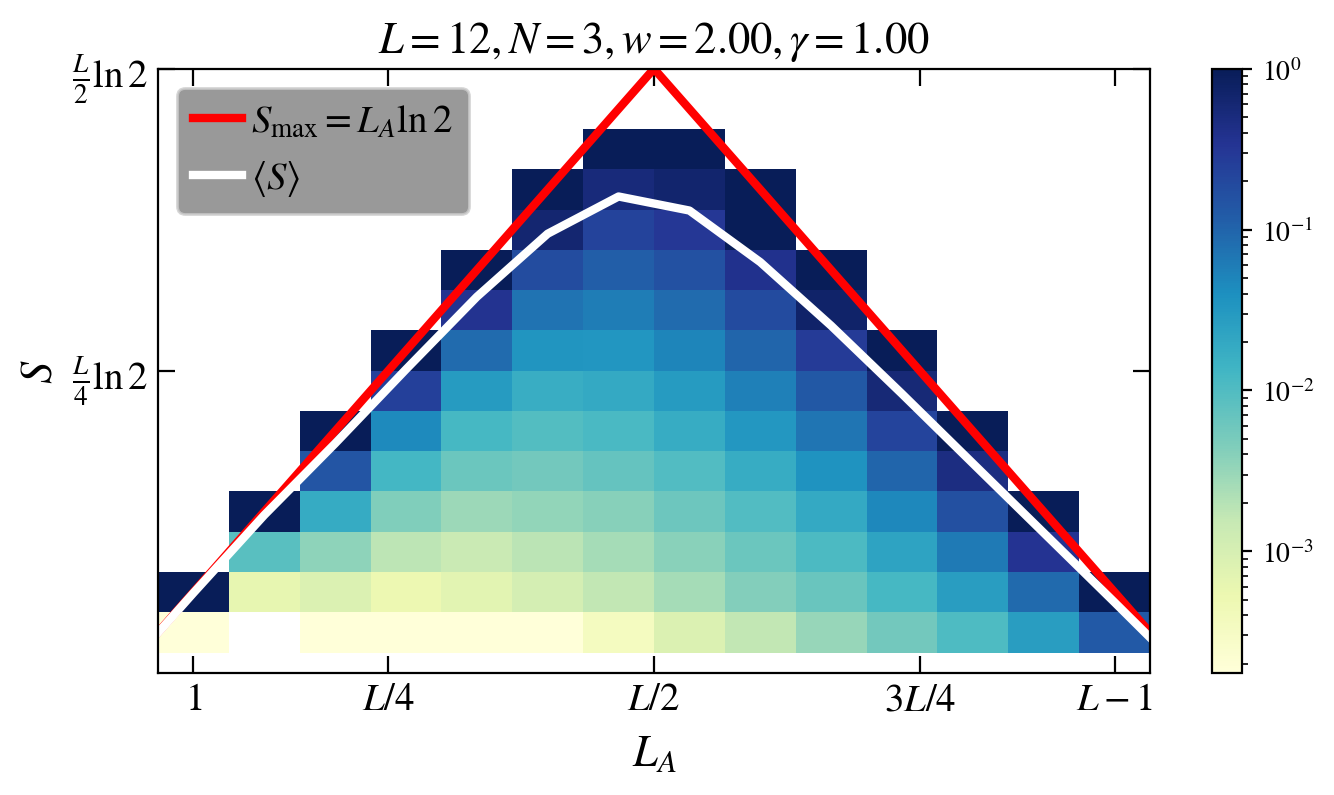

In [56]:

markers = itertools.cycle(markers_ls)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,4), dpi = 200)

L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

entrop = np.linspace(0, L_total * np.log(2)/2, L_total + 1)
sub_sizes = np.arange(0, L_total+1)

density = np.zeros((sub_sizes.size, entrop.size-1))

average_entropy = np.zeros((sub_sizes.size))

name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
if exists(name):
    with h5py.File(name, "r") as file:
        energies = np.array(file.get('mean energies'))
        dim = energies.size

        for LA in sub_sizes:
            entropies = np.array(file.get('entropies'))[LA]

            hist, bins = np.histogram(entropies, bins=entrop, normed=True)
            hist = np.array(hist)
            #
            #hist.resize( sub_sizes.size )
            #print(bins, hist)
            density[LA] = np.array(hist)
            average_entropy[LA] = np.mean(entropies)
else:
    print(name)

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(sub_sizes, entrop[1:])
print(X, Y)
p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, norm=matplotlib.colors.LogNorm(vmin=np.min(density[density > 0]), vmax=1.0))

laa = np.arange(0, L_total//2 + L_total%2 + 1)
axis.plot(laa, laa * np.log(2), c='red', lw=3)
laa = np.arange(L_total//2, L_total+1)
axis.plot(laa, (L_total - laa)*np.log(2), c='red', lw=3, label=r"$S_{\rm max}=L_A\ln2$")

axis.plot(sub_sizes, average_entropy, lw=3, c='white', label=r"$\langle S\rangle$")
axis.set_xlim(0.5, L_total-0.5)
axis.set_ylim(0.0, L_total/2*np.log(2))

fig_help.set_plot_elements(axis, ylabel="$S$", xlabel=r"$L_A$", font_size=14, set_legend=False)

xticks = [1, L_total/4, L_total/2, 3*L_total/4, L_total-1]
tick_labels = ["$1$", "$L/4$", "$L/2$", "$3L/4$", "$L-1$"]
axis.set_xticks(xticks)
axis.set_xticklabels(tick_labels)

xticks = [L_total/4*np.log(2), L_total/2*np.log(2)]
tick_labels = [r"$\frac{L}{4}\ln2$", r"$\frac{L}{2}\ln2$"]
axis.set_yticks(xticks)
axis.set_yticklabels(tick_labels)
axis.set_title(r"$L=%d, N=%d, w=%.2f, \gamma=%.2f$"%(L,N, w, gamma), fontsize=16)

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
fig.colorbar(p)
legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

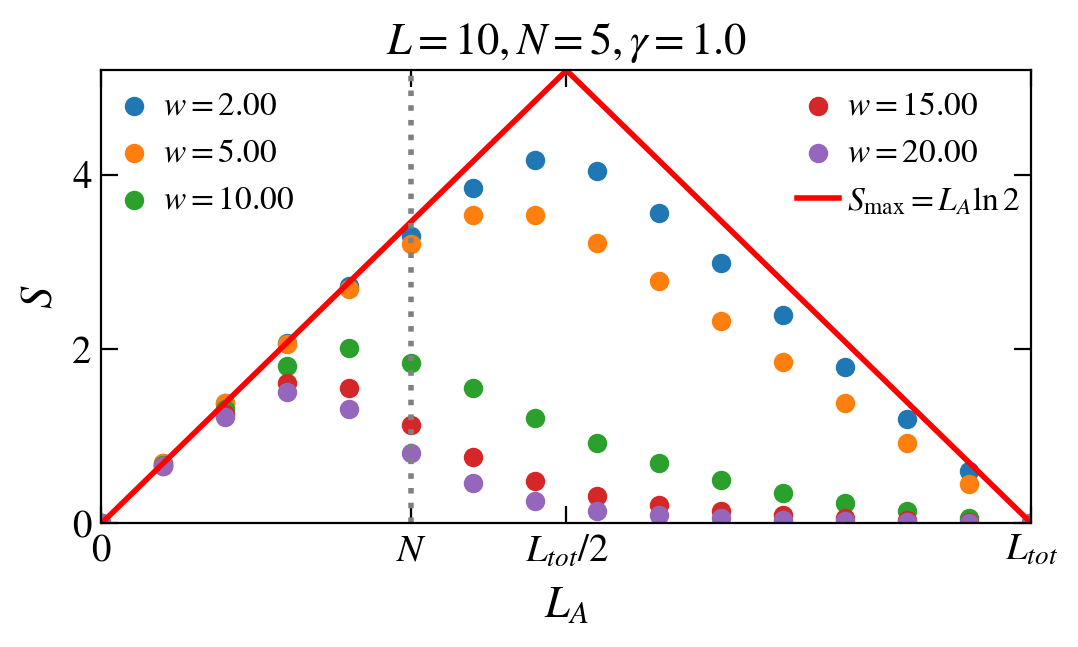

In [57]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=5
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L_total+1)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(6,3), dpi = 200)

def frac(dim):
    return 2*dim

for w in [2.0, 5.0, 10.0, 15.0, 20.0]:
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    entropy = np.zeros((L_total+1))
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            ratio = np.array(file.get('gap ratio'))
            entropies = np.array(file.get('entropies'))
            
            dim = energies.size
            num = frac(dim)

            E_av = np.mean(energies)
            index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
            
            for LA in sub_sizes:
                my_min = int(index_meanE - num / 2)
                if my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2) 
                if my_max >= dim: my_max = dim

                sample = entropies[LA]
                if my_min > 0 and my_max < dim:
                    sample = entropies[LA][my_min : my_max]
                
                entropy[LA] = np.mean(sample)
                
        axis.scatter(sub_sizes, entropy, label=r"$w=%.2f$"%w)
    else:
        print(name)
laa = np.arange(0, L_total//2 + (L_total%2) + 0.5)
axis.plot(laa, laa * np.log(2), c='red', lw=2)
laa = np.arange(L_total//2, L_total + 1)
axis.plot(laa, (L_total - laa)*np.log(2), c='red', lw=2, label=r"$S_{\rm max}=L_A\ln2$")

axis.axvline(x=N, ls=':', color='gray', lw=2)
fig_help.set_plot_elements(axis, ylabel="$S$", xlabel=r"$L_A$", font_size=14, set_legend=True)
axis.set_xlim(0, L_total)
axis.set_ylim(0, L_total/2 * np.log(2))

xticks = [0, N, L_total/2, L_total]
tick_labels = ["$0$", "$N$", "$L_{tot}/2$", "$L_{tot}$"]
axis.set_xticks(xticks)
axis.set_xticklabels(tick_labels)
axis.set_title(r"$L=%d, N=%d, \gamma=%.1f$"%(L,N, gamma), fontsize=16)

handles, labels = axis.get_legend_handles_labels()

split_idx = 4
l1 = axis.legend(handles=handles[1:split_idx], labels=labels[1:split_idx], loc = 'upper left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,1.02))
hand = [*handles[split_idx:], handles[0]]
labs = [*labels[split_idx:], labels[0]]
l2 = axis.legend(handles=hand, labels=labs, loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.02,1.02))
plt.gca().add_artist(l1)

## FUNCTION OF DISORDER

### BIPARTITE ENTANGLEMENT

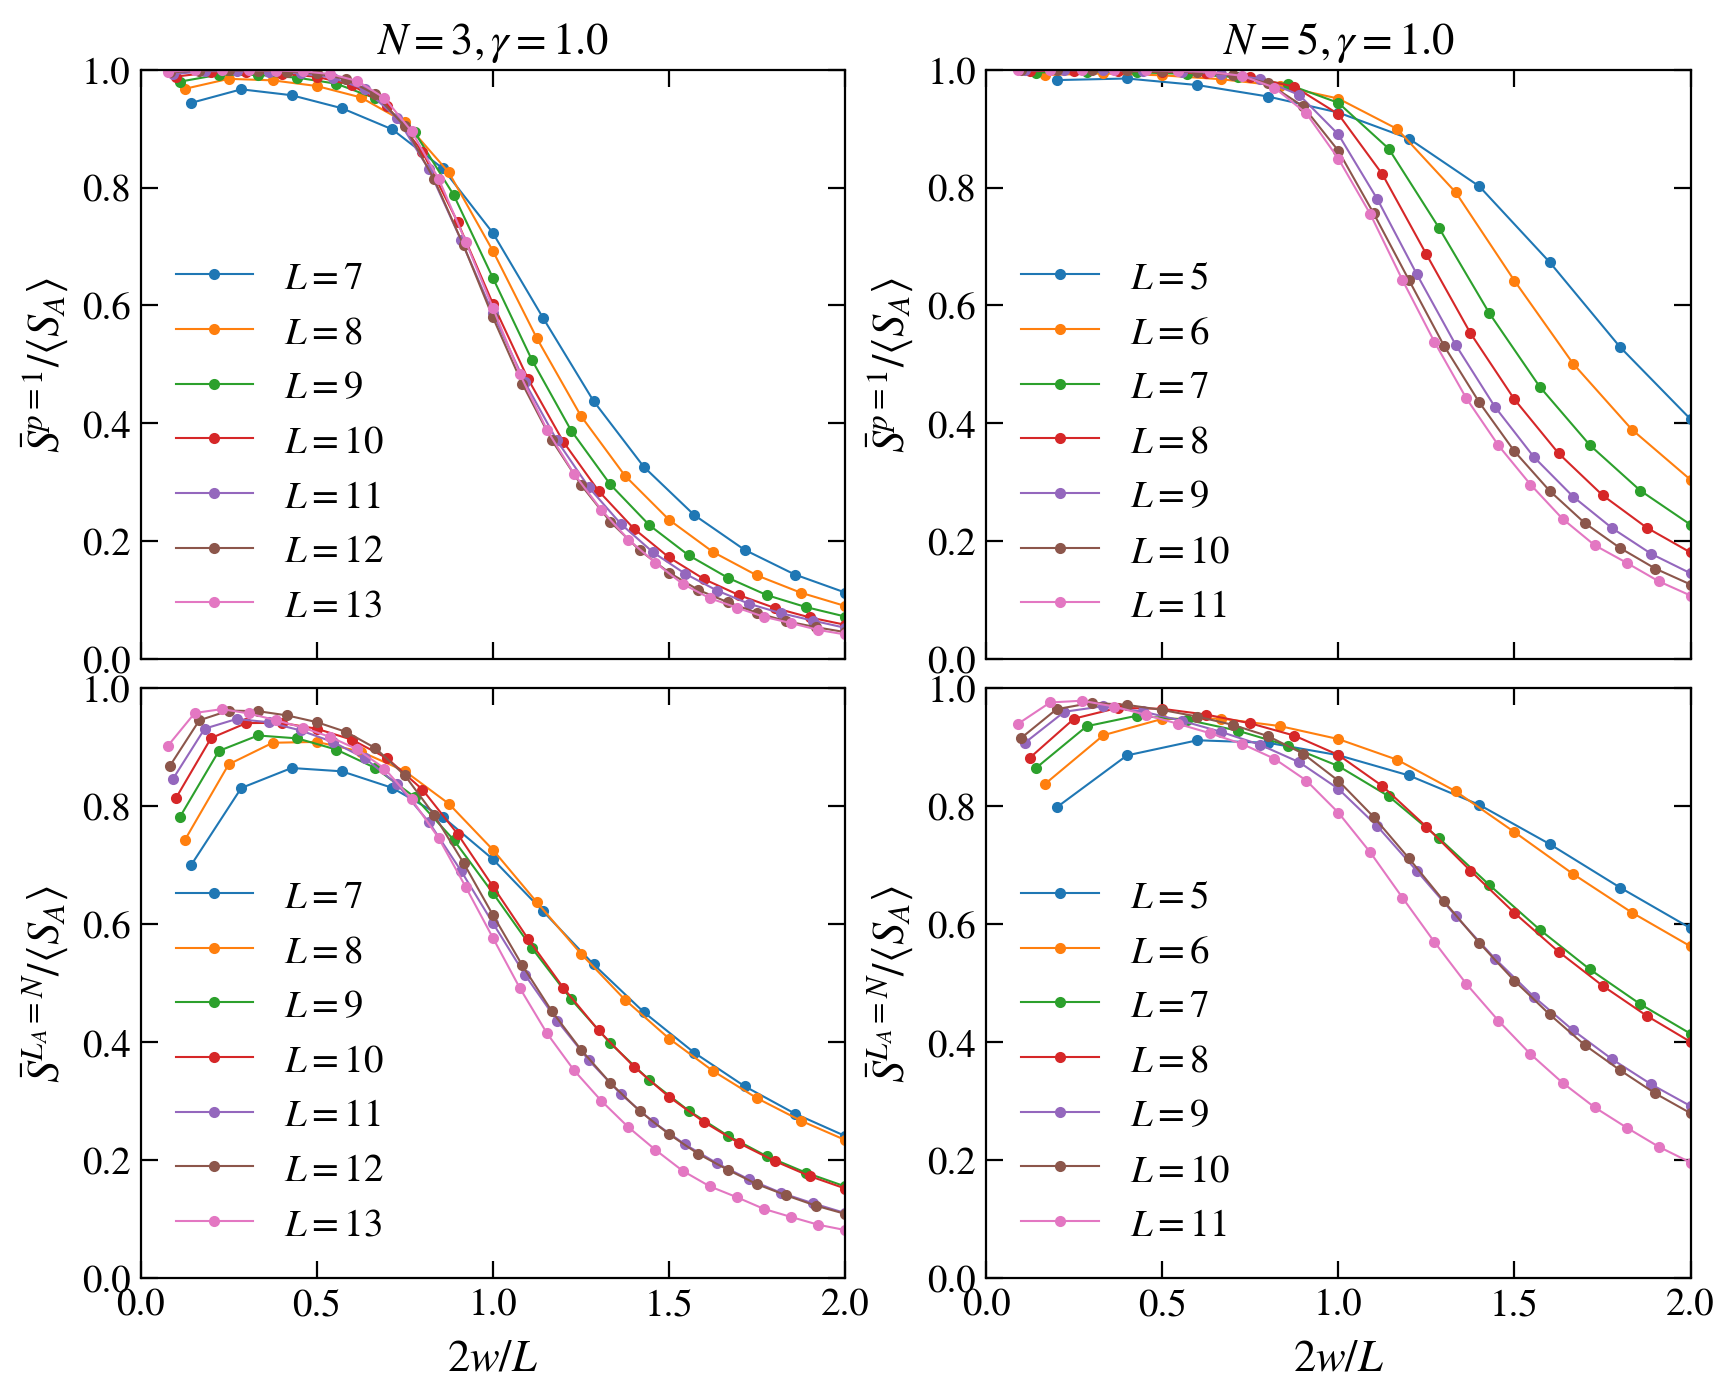

In [301]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200)


def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(10, 17, 1):
        L = L_total - N
        LA = L_total // 2
        for idx2, LA in enumerate([L_total - 1, L_total//2]):
            entropy = np.zeros((w_vals.size))
            gap_ratio = np.zeros((w_vals.size))
            for ii, w in enumerate(w_vals):
                name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
                #print(name)
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        
                        S = np.array(file.get('entropies'))[LA]
                        realis = np.array(file.get('realisations'))
                        
                        dim = energies.size
                        num = frac(dim)

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2) 
                        if my_max >= dim: my_max = dim

                        sample = S
                        if num < dim and my_min > 0 and my_max < dim:
                            sample = S[my_min : my_max]
                        
                        entropy[ii] = np.mean(sample)
                        gap_ratio[ii] = np.mean(ratio)
                else:
                    print(name)
            axis[idx2][idx1].plot(2*w_vals / L, entropy / page(LA, L_total - LA), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
            #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
            axis[idx2][idx1].set_ylim(0.0,1)
            axis[idx2][idx1].set_xlim(0, 2)
fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar{S}^{L_A=N} / \langle S_A\rangle$", xlabel=r"$2w / L$", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[1][1], ylabel=r"$\bar{S}^{L_A=N} / \langle S_A\rangle$", xlabel=r"$2w / L$", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar{S}^{p=1} / \langle S_A\rangle$", xlabel="", font_size=14, set_legend=True)
fig_help.set_plot_elements(axis[0][1], ylabel=r"$\bar{S}^{p=1} / \langle S_A\rangle$", xlabel="", font_size=14, set_legend=True)


axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

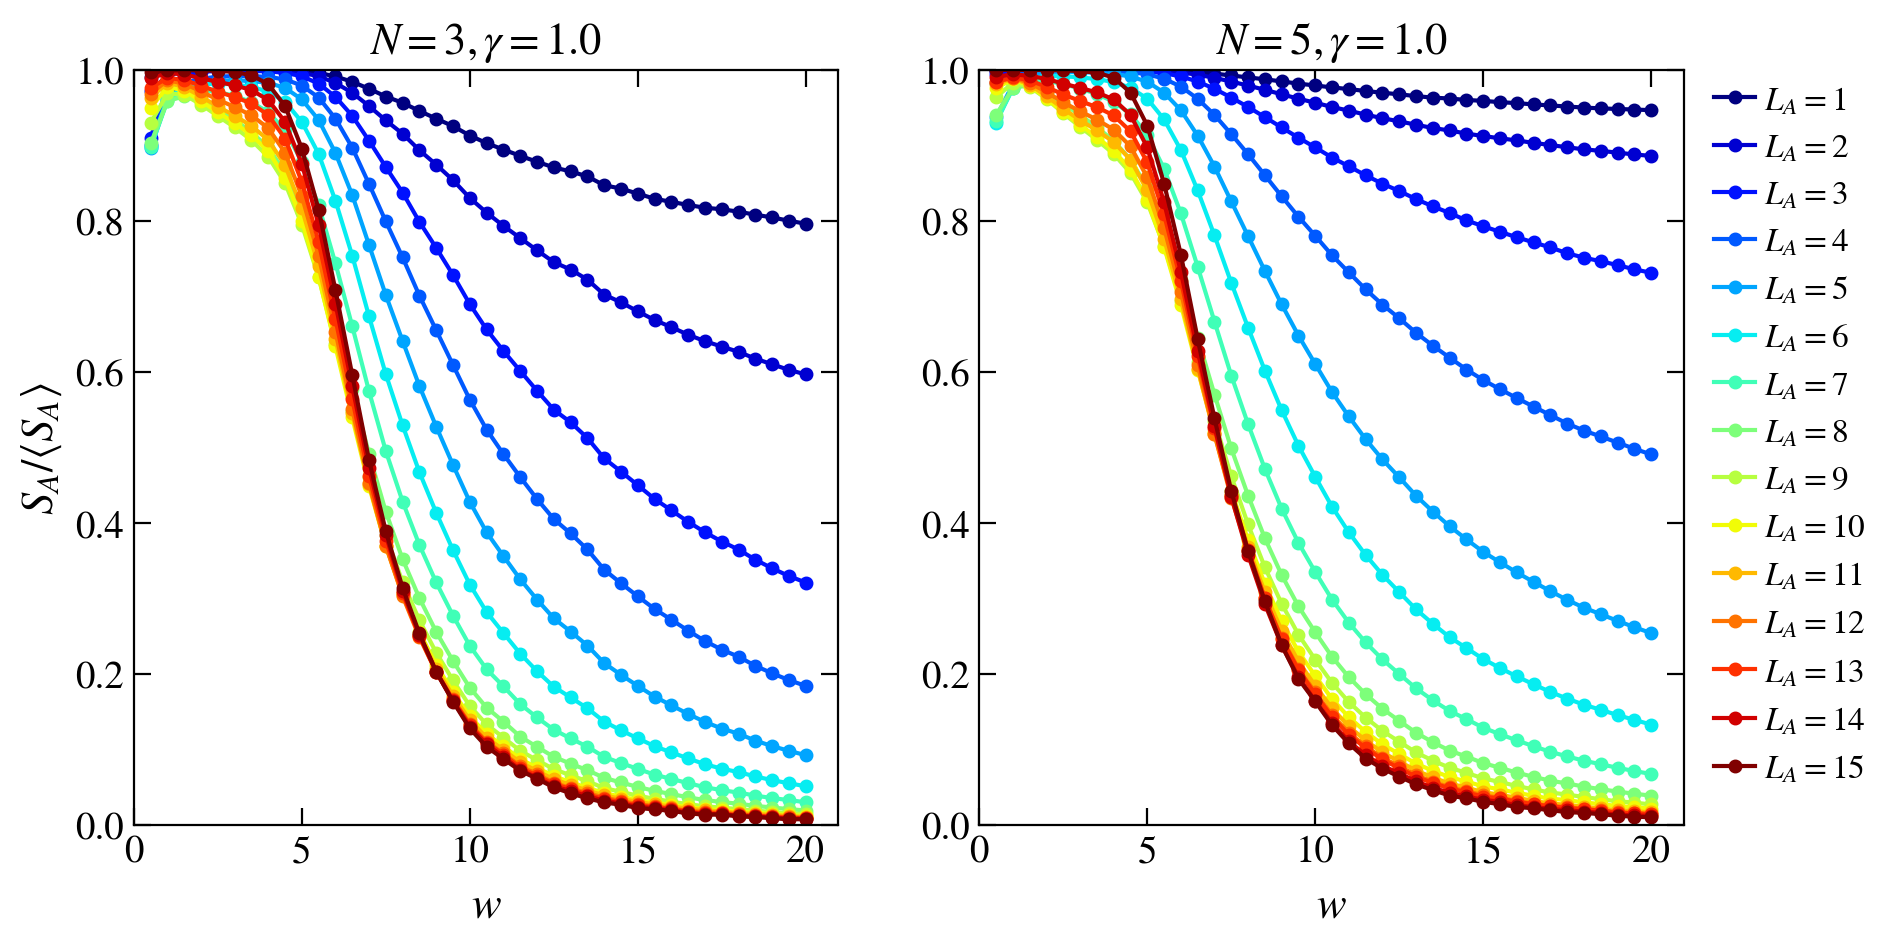

In [282]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L_total + 1)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size-2))
    L = L_total - N
    for LA in sub_sizes[1:-1]:
        entropy = np.zeros((w_vals.size))
        gap_ratio = np.zeros((w_vals.size))
        for ii, w in enumerate(w_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            #print(name)
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    S = np.array(file.get('entropies'))[LA]
                    
                    dim = energies.size
                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = S
                    if my_min > 0 and my_max < dim:
                        sample = S[my_min : my_max]
                    
                    entropy[ii] = np.mean(sample)
                    gap_ratio[ii] = np.mean(ratio)
            else:
                print(name)
        axis[idx1].plot(w_vals, entropy / page(LA, L_total - LA), marker='o', markersize=4, label=r"$L_A=%d$"%LA, color=colors[LA-1])
        #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
        axis[idx1].set_ylim(0,1)
        axis[idx1].set_xlim(0, None)
fig_help.set_plot_elements(axis[0], ylabel=r"$S_{A} / \langle S_A\rangle$", xlabel=r"$w$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], ylabel="",                              xlabel=r"$w$", font_size=14, set_legend=False)


axis[0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
axis[1].legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.3,1.02))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

[[3.16227766e-04 3.16227766e-04 3.16227766e-04 ... 3.16227766e-04
  3.16227766e-04 3.16227766e-04]
 [3.49083477e-04 3.49083477e-04 3.49083477e-04 ... 3.49083477e-04
  3.49083477e-04 3.49083477e-04]
 [3.85352859e-04 3.85352859e-04 3.85352859e-04 ... 3.85352859e-04
  3.85352859e-04 3.85352859e-04]
 ...
 [4.18034496e+00 4.18034496e+00 4.18034496e+00 ... 4.18034496e+00
  4.18034496e+00 4.18034496e+00]
 [4.61467812e+00 4.61467812e+00 4.61467812e+00 ... 4.61467812e+00
  4.61467812e+00 4.61467812e+00]
 [5.09413801e+00 5.09413801e+00 5.09413801e+00 ... 5.09413801e+00
  5.09413801e+00 5.09413801e+00]]
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.

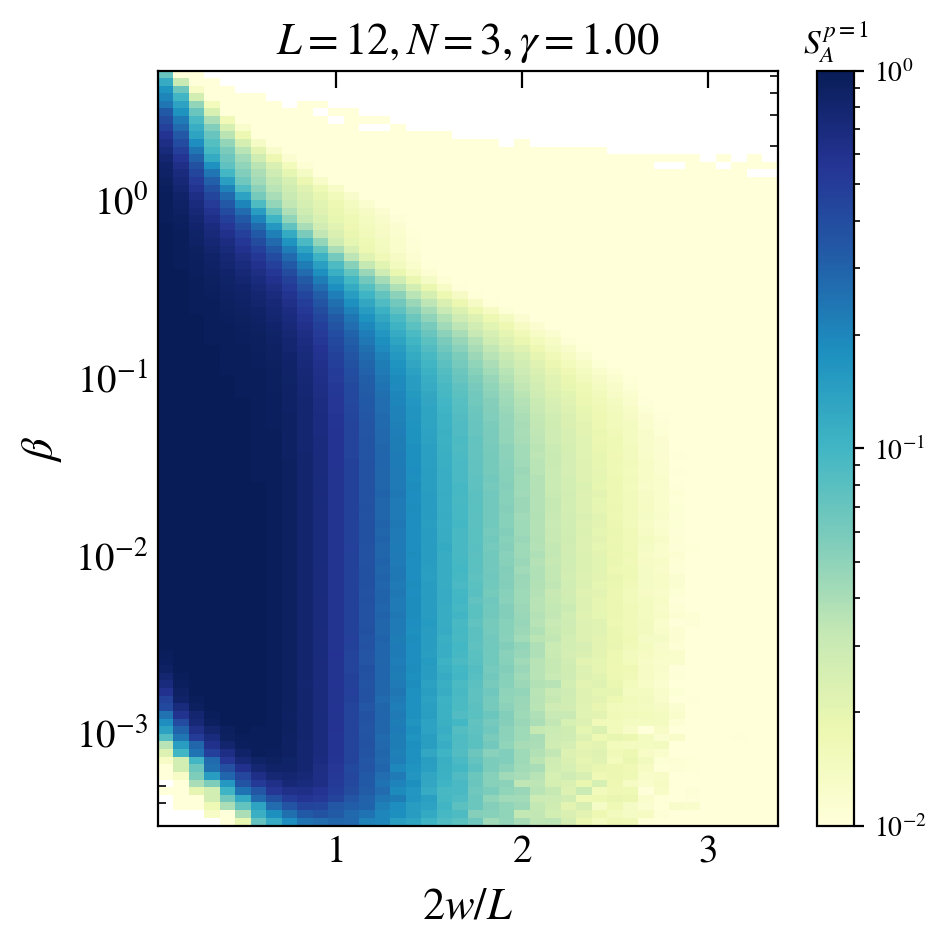

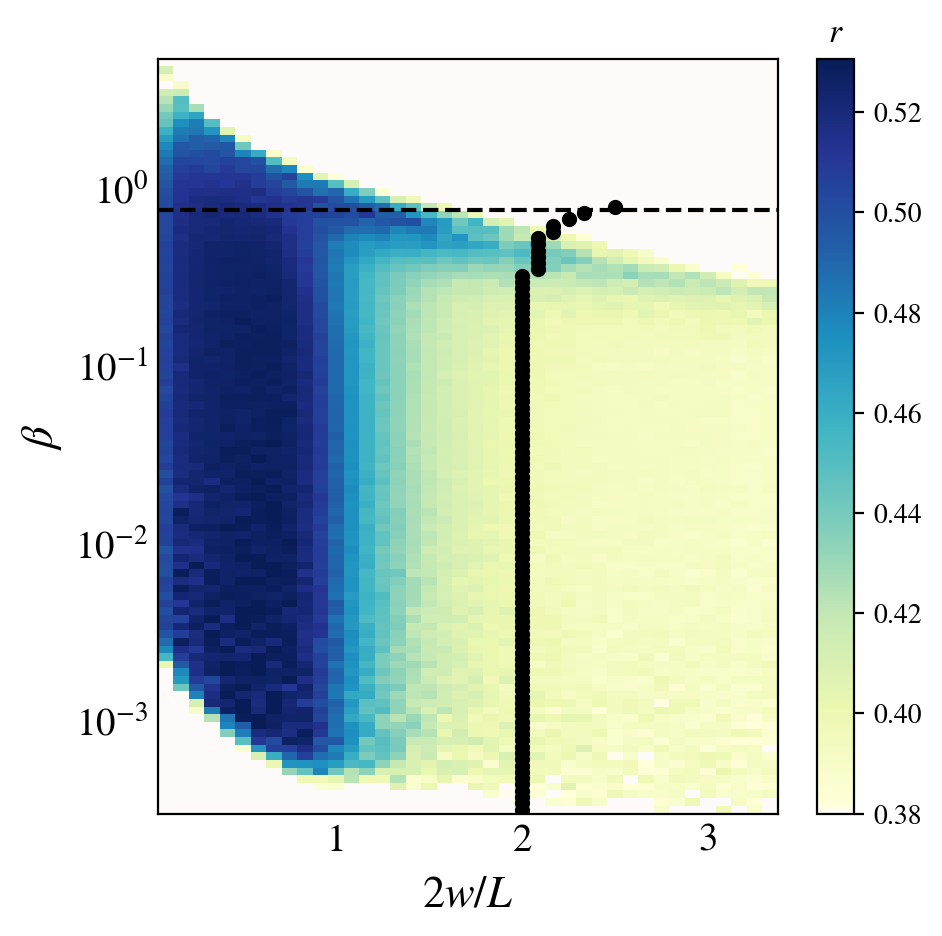

In [601]:

markers = itertools.cycle(markers_ls)


L_total=15

fig1, axis1 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
fig2, axis2 = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)
axis = [axis1, axis2]

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)
sub_sizes = np.arange(0, L_total+1)

density = np.zeros((sub_sizes.size, w_vals.size))

def frac(dim):
    return 200

temperature = True

LA = L_total - 1
energy_density = None
entropy_density = []
gap_ratio_density = []
for ii, w in enumerate(w_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='_beta.hdf5' if temperature else '.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energy_density = np.array(file.get('bins'))[:-1]
            S_dens = np.array(file.get('entropy density'))[LA]
            gap_ratio = np.array(file.get('gap ratio density'))
            
            entropy_density.append(S_dens / page(LA, L_total - LA))  
            gap_ratio_density.append(gap_ratio)  
    else:
        print(name)

energy_density = np.array(energy_density)
entropy_density = np.array(entropy_density)
gap_ratio_density = np.array(gap_ratio_density)

disorder = np.array([w_vals for _ in entropy_density])

white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(2 * w_vals / L, (energy_density))
print(Y)

p = axis1.pcolormesh(X, (Y), np.transpose(entropy_density), shading='nearest', cmap=mymap, norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0))
fig_help.set_plot_elements(axis1, ylabel=r"$\beta$" if temperature else r"$\epsilon$", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale = 'log' if temperature else 'linear')
axis1.set_title(r"$L=%d, N=%d, \gamma=%.2f$"%(L,N, gamma), fontsize=16)
clb = fig1.colorbar(p)
clb.ax.set_title(r"$S^{p=1}_A$")

colors = np.vstack((white, upper))  
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

p = axis2.pcolormesh(X, Y, np.transpose(gap_ratio_density), shading='nearest', cmap=mymap, vmin=0.38, vmax=0.5307)
fig_help.set_plot_elements(axis2, ylabel=r"$\beta$" if temperature else r"$\epsilon$", xlabel=r"$2w/L$", font_size=14, set_legend=False, yscale = 'log' if temperature else 'linear')
clb2 = fig2.colorbar(p)
clb2.ax.set_title(r"$r$")

from mpmath import polylog as Li

if temperature:
    betas = np.logspace(-3.5, 0., 100)
    w_crit = []
    for beta in betas:
        GR = np.sqrt(prediction_square_energy(beta, N) - prediction_mean_energy(beta, N)**2)
        Gloc = w_vals / L * np.sqrt(1 - np.tanh(beta * w_vals / L)**2)
        #Gloc = np.sqrt(w_vals**3 / 6 / L**3 - 1/4/beta**4 * (3.28987 - w_vals**2*beta**2/L**2 - 4*w_vals*beta/L*np.log(1+np.exp(-beta*w_vals/2)) + 4*Li(2,np.exp(-beta*w_vals/2)))**2 )
        y = GR - Gloc
        idx = min(range(len(w_vals)), key=lambda i: abs(y[i]))
        if any(y <= 0): 
            w_crit.append(w_vals[idx])
        else:
            w_crit.append(np.nan)
    print(w_crit)
    w_crit = np.array(w_crit)
    axis2.scatter(2 * w_crit / L, betas, marker='o', color='black', s=20)
    axis2.axhline(y=0.754869548695487, ls='--', color='black')
    
    #axis2.plot(np.sqrt(prediction_square_energy(np.sqrt(2**(N) / (2**N + 1)) * betas, N) - prediction_mean_energy(np.sqrt(2**(N) / (2**N + 1)) * betas, N)**2), betas, c='black', ls='--')
    #axis2.plot(np.sqrt(w**2/L**2/4 - w/L/2*np.tanh(betas*2/L)), betas, c='red', ls='--')

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())

#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

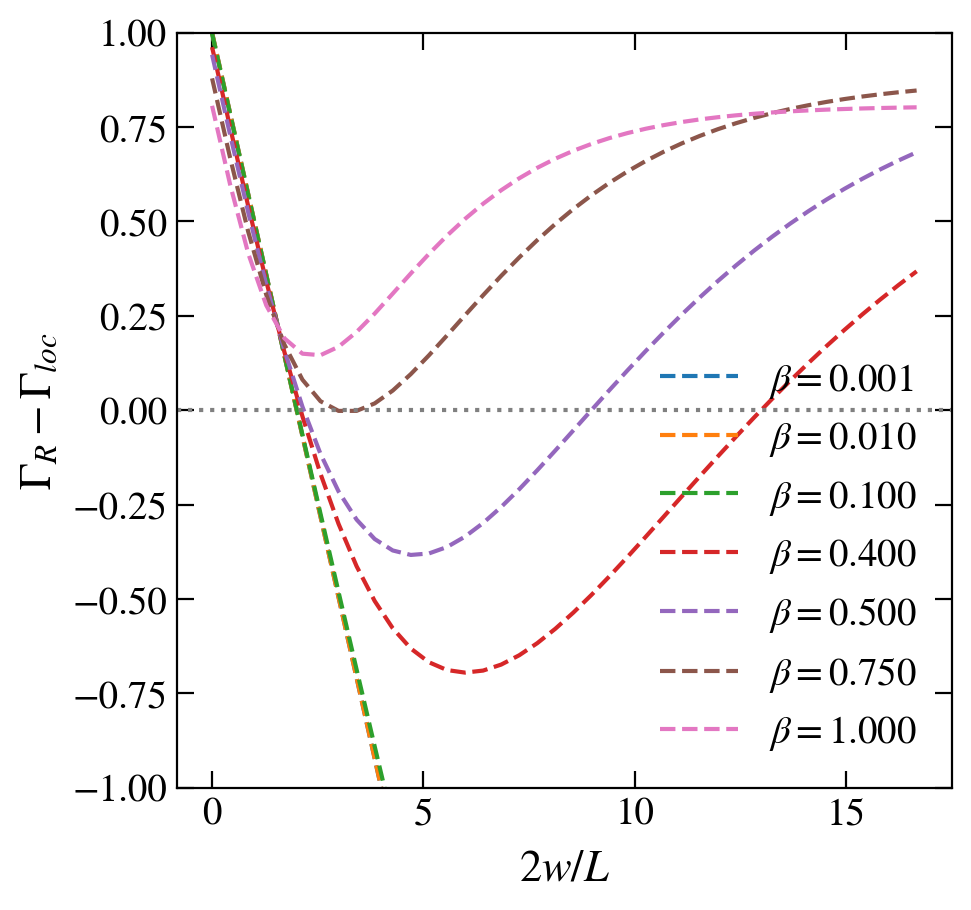

In [20]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200)

N=10
L=12

w = np.linspace(0, 100, 40)

betas = np.logspace(-3.5, 2, 1000)

for beta in [1e-3, 1e-2, 1e-1, 0.4, 0.5, 0.75, 1.0]:
    GR = np.sqrt(goe.energy_variance(beta, N) - goe.energy_mean(beta, N)**2)
    Gloc = w / L * np.sqrt(1 - np.tanh(beta * w / L)**2)
    #Gloc = np.sqrt(w_vals**3 / 6 / L**3 - 1/4/beta**4 * (3.28987 - w_vals**2*beta**2/L**2 - 4*w_vals*beta/L*np.log(1+np.exp(-beta*w_vals/L)))**2 )
    y = GR - Gloc
    axis.plot(2*w/L, GR - Gloc, ls='--', label=r"$\beta=%.3f$"%beta)

axis.set_ylim(-1,1)
axis.axhline(y=0.0, ls=':', color='gray')
fig_help.set_plot_elements(axis, xlabel=r"$2w/L$", ylabel=r"$\Gamma_R-\Gamma_{loc}$", font_size=14, set_legend=True, xscale = 'linear')

# for beta in np.linspace(0.7, 0.756, 100000):
#     GR = np.sqrt(prediction_square_energy(beta, N) - prediction_mean_energy(beta, N)**2)
#     Gloc = w / L * np.sqrt(1 - np.tanh(beta * w / L)**2)
#     y = GR - Gloc
#     if all(y >= 0):
#         print(beta)
    

### SINGLE - SITE ENTANGLENT

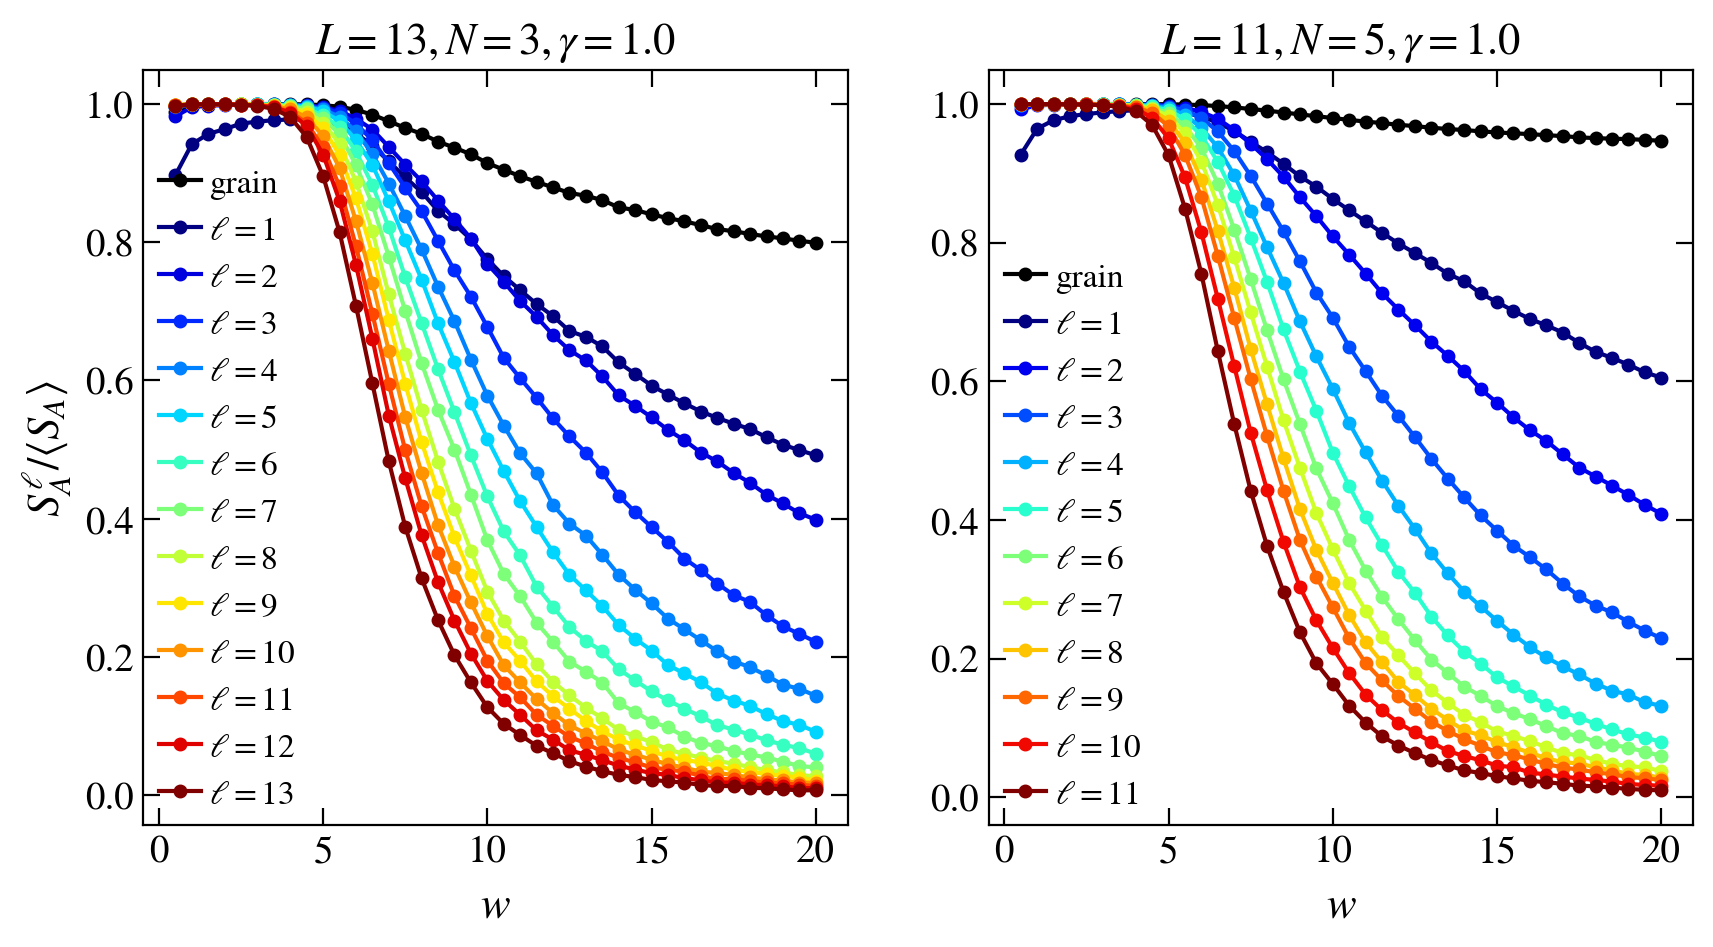

In [292]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.5, 20., 40)

fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200)

def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    sub_sizes = np.arange(N - 1, L_total + 1)

    L = L_total - N
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))
    for col_idx, ell in enumerate(sub_sizes[: -1]):
        entropy = np.zeros((w_vals.size))
        gap_ratio = np.zeros((w_vals.size))
        for ii, w in enumerate(w_vals):
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            #print(name)
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    S = np.array(file.get('single_site_entropy'))[ell]
                    
                    dim = energies.size
                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = S
                    if num < dim and my_min > 0 and my_max < dim:
                        sample = S[my_min : my_max]
                    
                    entropy[ii] = np.mean(sample)
                    gap_ratio[ii] = np.mean(ratio)
            else:
                print(name)

        ydata = entropy / page(1, L_total - 1)
        axis[idx1].plot(w_vals, ydata, marker='o', markersize=4, label=r"$\ell=%d$"%(ell - N + 1) if ell >= N else "grain", color=colors[col_idx-1] if ell >=N else 'black')
        #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
        #axis[idx1].set_ylim(0,1)
        #axis[idx1].set_xlim(0, None)
fig_help.set_plot_elements(axis[0], ylabel=r"$S^{\ell}_A / \langle S_A\rangle$", xlabel=r"$w$", font_size=14, set_legend=False)
fig_help.set_plot_elements(axis[1], ylabel="", xlabel=r"$w$", font_size=14, set_legend=False)


axis[0].set_title(r"$L=%d, N=3, \gamma=%.1f$"%(L_total - 3,gamma), fontsize=16)
axis[1].set_title(r"$L=%d, N=5, \gamma=%.1f$"%(L_total - 5,gamma), fontsize=16)
axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

56.33354748374999
18.704344837249028
8.180524021253875
5.354973532118066
4.225164344662404
3.5843186085929304
3.2659404783860113
3.0126148778057575
2.883311394618691
43.80194879440621
16.639895320831872
7.37776680968277
4.841776103153848
3.7650444045942515
3.242819157655579
2.9520184692631073
2.759045866287416
2.591522913030915


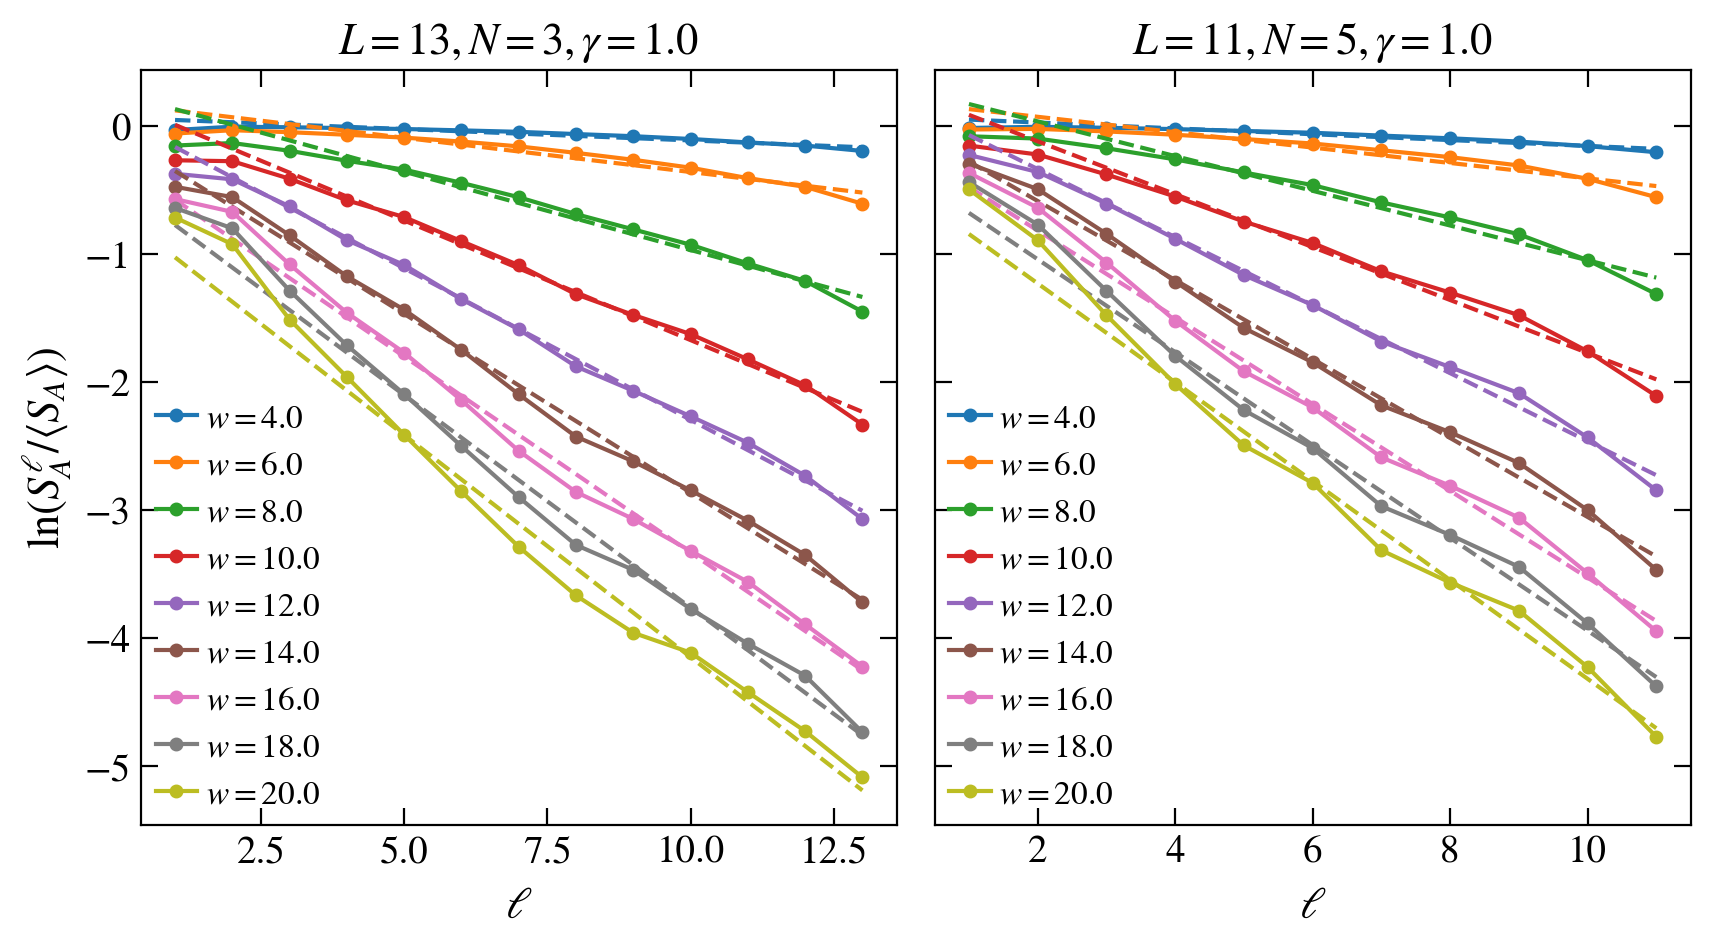

In [643]:
L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0

w_vals = np.linspace(0.5, 20., 40)
w_vals = np.arange(4, 21, 2)
fig, axis = plt.subplots( nrows=1, ncols=2, figsize=(10,5), dpi = 200, sharey=True)

def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    sub_sizes = np.arange(N, L_total)

    L = L_total - N
    colors = plt.cm.jet(np.linspace(0, 1, sub_sizes.size - 2))
    for ii, w in enumerate(w_vals):
        entropy = np.zeros((sub_sizes.size))
        for ell in sub_sizes:
            name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
            #print(name)
            if exists(name):
                with h5py.File(name, "r") as file:
                    energies = np.array(file.get('mean energies'))
                    ratio = np.array(file.get('gap ratio'))
                    S = np.array(file.get('single_site_entropy'))[ell]
                    
                    dim = energies.size
                    num = frac(dim)

                    E_av = np.mean(energies)
                    index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                    
                    my_min = int(index_meanE - num / 2)
                    if my_min < 0: my_min = 0;  

                    my_max = int(index_meanE + num / 2) 
                    if my_max >= dim: my_max = dim

                    sample = S
                    if num < dim and my_min > 0 and my_max < dim:
                        sample = S[my_min : my_max]
                    
                    entropy[ell - N] = np.mean(sample)
                    gap_ratio[ell - N] = np.mean(ratio)
            else:
                print(name)

        xdata = sub_sizes - N + 1
        ydata = np.log(entropy / page(1, L_total - 1))
        plo = axis[idx1].plot(xdata, ydata, marker='o', markersize=4, label=r"$w=%.1f$"%(w))
        pars, pconv = fit(lin_fit,
                        xdata = xdata[2:],
                        ydata = ydata[2:])
        axis[idx1].plot(xdata, lin_fit(xdata, *pars), ls='--', color=plo[0].get_color())
        xi = pars[0]
        print(xi)
    fig_help.set_plot_elements(axis[idx1], ylabel=r"$\ln (S^{\ell}_A / \langle S_A\rangle)$" if idx1 == 0 else "", xlabel=r"$\ell$", font_size=14, set_legend=not idx1, yscale='linear')


axis[0].set_title(r"$L=%d, N=3, \gamma=%.1f$"%(L_total - 3,gamma), fontsize=16)
axis[1].set_title(r"$L=%d, N=5, \gamma=%.1f$"%(L_total - 5,gamma), fontsize=16)
axis[0].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
axis[1].legend(loc = 'lower left', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(-0.02,-0.02))
fig.subplots_adjust(wspace = 0.05, hspace=0.05)

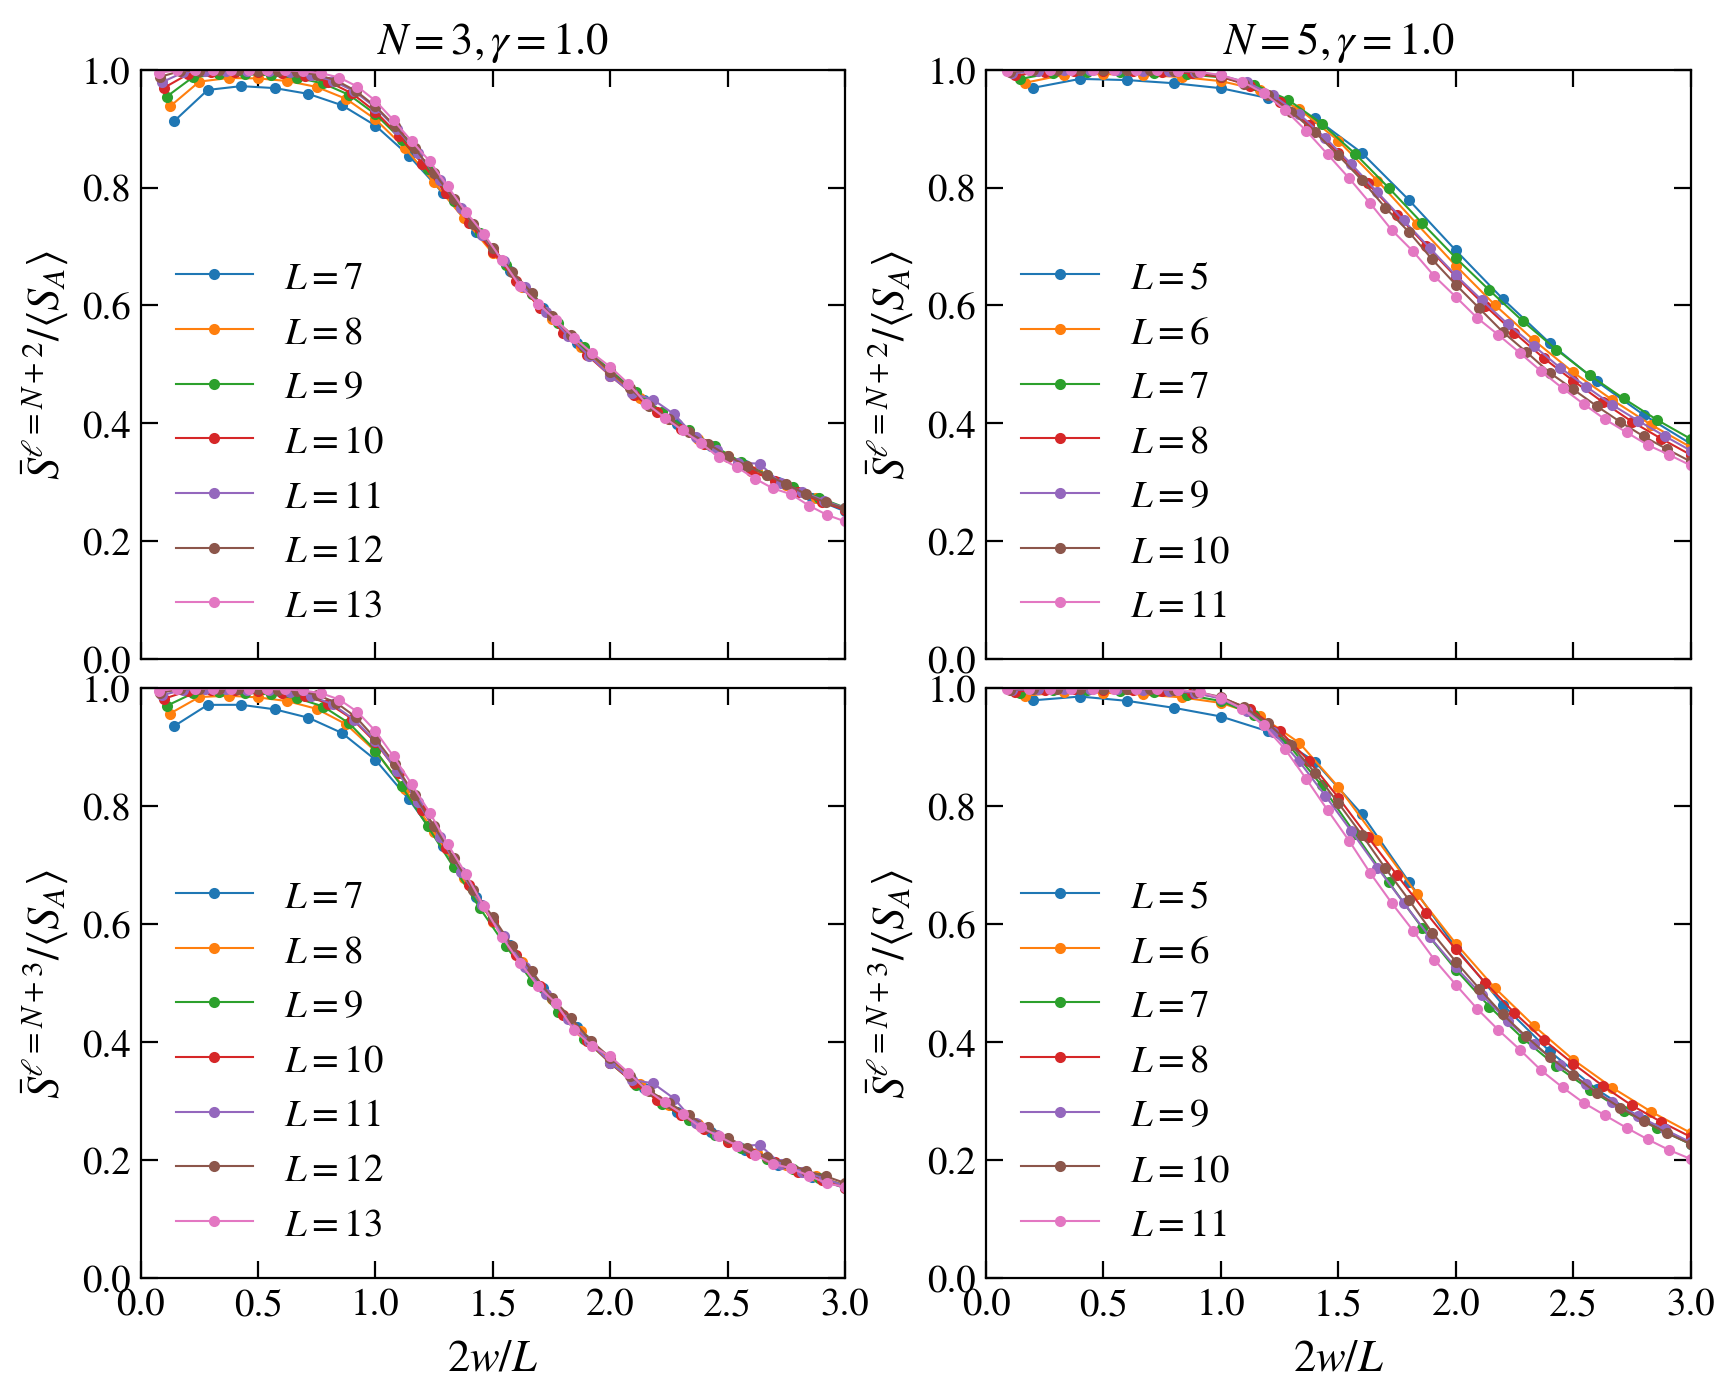

In [290]:
L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)

sub_sizes = np.arange(0, L+1)
fig, axis = plt.subplots( nrows=2, ncols=2, figsize=(10,8), dpi = 200)


def frac(dim):
    return 500

for idx1, N in enumerate([3, 5]):
    for L_total in np.arange(10, 17):
        L = L_total - N
        for idx2, ell in enumerate([N+2, N+3]):
            entropy = np.zeros((w_vals.size))
            gap_ratio = np.zeros((w_vals.size))
            for ii, w in enumerate(w_vals):
                name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
                #print(name)
                if exists(name):
                    with h5py.File(name, "r") as file:
                        energies = np.array(file.get('mean energies'))
                        ratio = np.array(file.get('gap ratio'))
                        
                        S = np.array(file.get('single_site_entropy'))[ell]
                        realis = np.array(file.get('realisations'))
                        
                        dim = energies.size
                        num = frac(dim)

                        E_av = np.mean(energies)
                        index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                        
                        my_min = int(index_meanE - num / 2)
                        if my_min < 0: my_min = 0;  

                        my_max = int(index_meanE + num / 2) 
                        if my_max >= dim: my_max = dim

                        sample = S
                        if num < dim and my_min > 0 and my_max < dim:
                            sample = S[my_min : my_max]
                        
                        entropy[ii] = np.mean(sample)
                        gap_ratio[ii] = np.mean(ratio)
                else:
                    print(name)
            axis[idx2][idx1].plot(2*w_vals / L, entropy / page(1, L_total - 1), marker='o', markersize=3, lw=0.75, label=r"$L=%d$"%L)
            #axis.plot(w_vals, gap_ratio, marker='o', label=r"$L=%d$"%L)
            axis[idx2][idx1].set_ylim(0, 1)
            axis[idx2][idx1].set_xlim(0, 3.0)
fig_help.set_plot_elements(axis[1][0], ylabel=r"$\bar{S}^{\ell=N+3} / \langle S_A\rangle$", xlabel=r"$2w / L$", font_size=14, set_legend=True, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[1][1], ylabel=r"$\bar{S}^{\ell=N+3} / \langle S_A\rangle$", xlabel=r"$2w / L$", font_size=14, set_legend=True, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][0], ylabel=r"$\bar{S}^{\ell=N+2} / \langle S_A\rangle$", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[0][1], ylabel=r"$\bar{S}^{\ell=N+2} / \langle S_A\rangle$", xlabel="",         font_size=14, set_legend=True, yscale='linear', xscale='linear')


axis[0][0].set_title(r"$N=3, \gamma=%.1f$"%(gamma), fontsize=16)
axis[0][1].set_title(r"$N=5, \gamma=%.1f$"%(gamma), fontsize=16)
# axis[0][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
# axis[1][1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
axis[0][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: ""))
fig.subplots_adjust(wspace = 0.2, hspace=0.05)

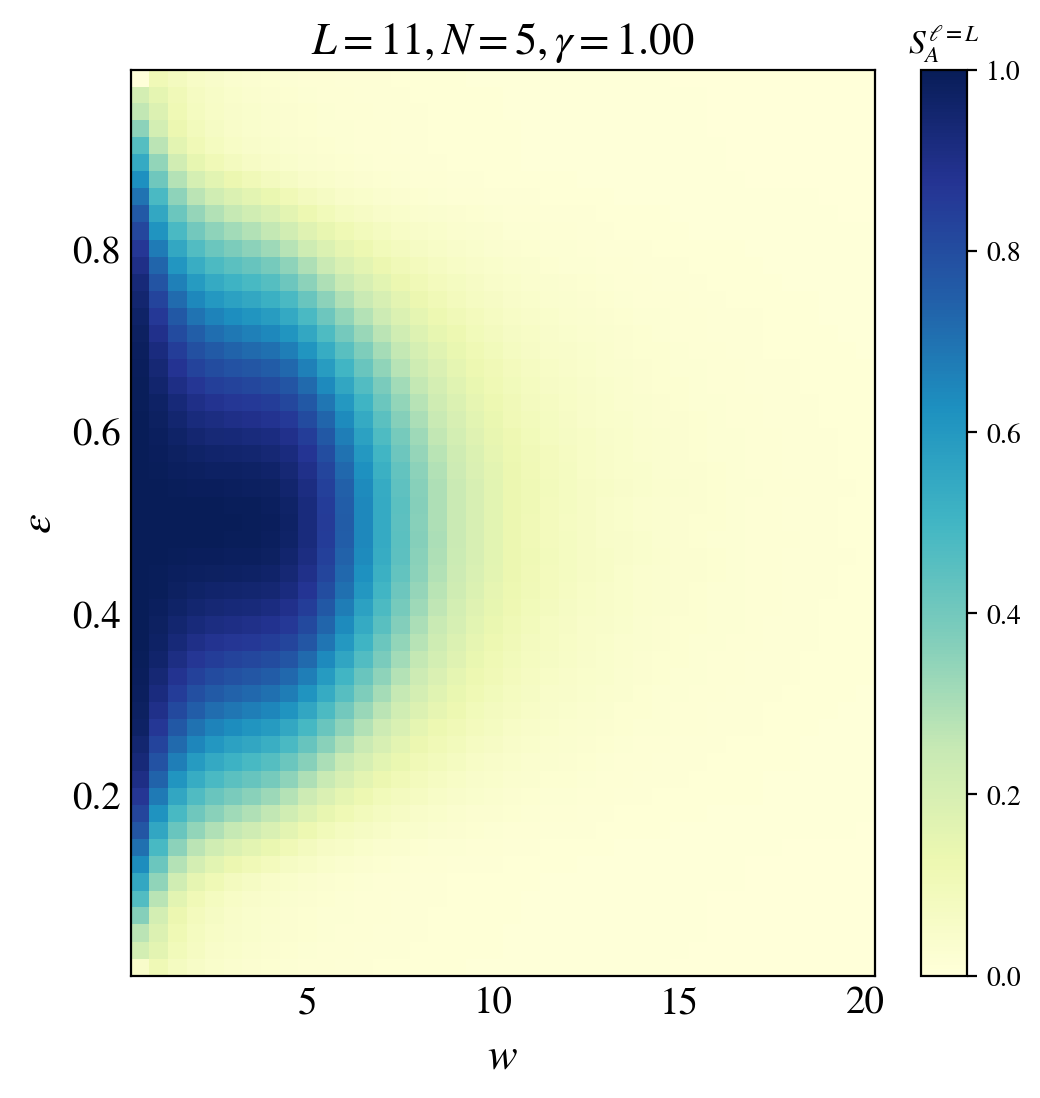

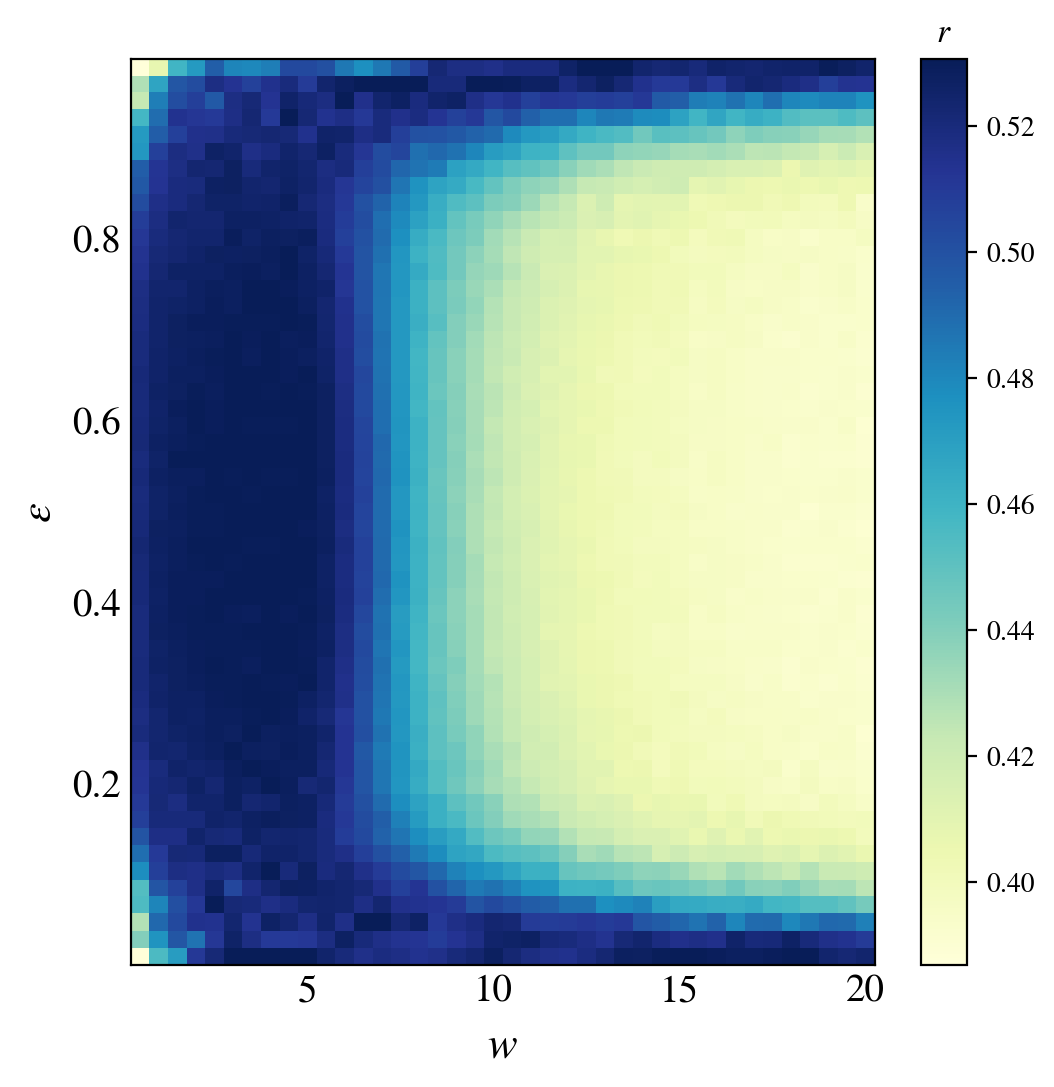

In [293]:

markers = itertools.cycle(markers_ls)


L_total=16

fig1, axis1 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
fig2, axis2 = plt.subplots( nrows=1, ncols=1, figsize=(6,6), dpi = 200)
axis = [axis1, axis2]

J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=5
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)
sub_sizes = np.arange(0, L_total+1)

density = np.zeros((sub_sizes.size, w_vals.size))

def frac(dim):
    return 500

ell = L_total-1

energy_density = None
entropy_density = []
gap_ratio_density = []
for ii, w in enumerate(w_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energy_density = np.array(file.get('energy density'))
            S_dens = np.array(file.get('entropy density'))[ell]
            gap_ratio = np.array(file.get('gap ratio density'))
            
            entropy_density.append(S_dens / page(1, L_total - 1))  
            gap_ratio_density.append(gap_ratio)  
    else:
        print(name)

energy_density = np.array(energy_density)
entropy_density = np.array(entropy_density)

disorder = np.array([w_vals for _ in entropy_density[0]])

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(w_vals, energy_density)

p = axis1.pcolormesh(X, Y, np.transpose(entropy_density), shading='nearest', cmap=mymap, vmin=0, vmax=1)
fig_help.set_plot_elements(axis1, ylabel=r"$\epsilon$", xlabel=r"$w$", font_size=14, set_legend=False)
axis1.set_title(r"$L=%d, N=%d, \gamma=%.2f$"%(L,N, gamma), fontsize=16)
clb = fig1.colorbar(p)
clb.ax.set_title(r"$S^{\ell=L}_A$")

p = axis2.pcolormesh(X, Y, np.transpose(gap_ratio_density), shading='nearest', cmap=mymap, vmin=0.3869, vmax=0.5307)
fig_help.set_plot_elements(axis2, ylabel=r"$\epsilon$", xlabel=r"$w$", font_size=14, set_legend=False)
clb2 = fig2.colorbar(p)
clb2.ax.set_title(r"$r$")

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())

#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

### HEATMAP VS SUBSYSTEM SIZE AND DISORDER

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
 [ 0  1  2  3  4  5  6  7  8

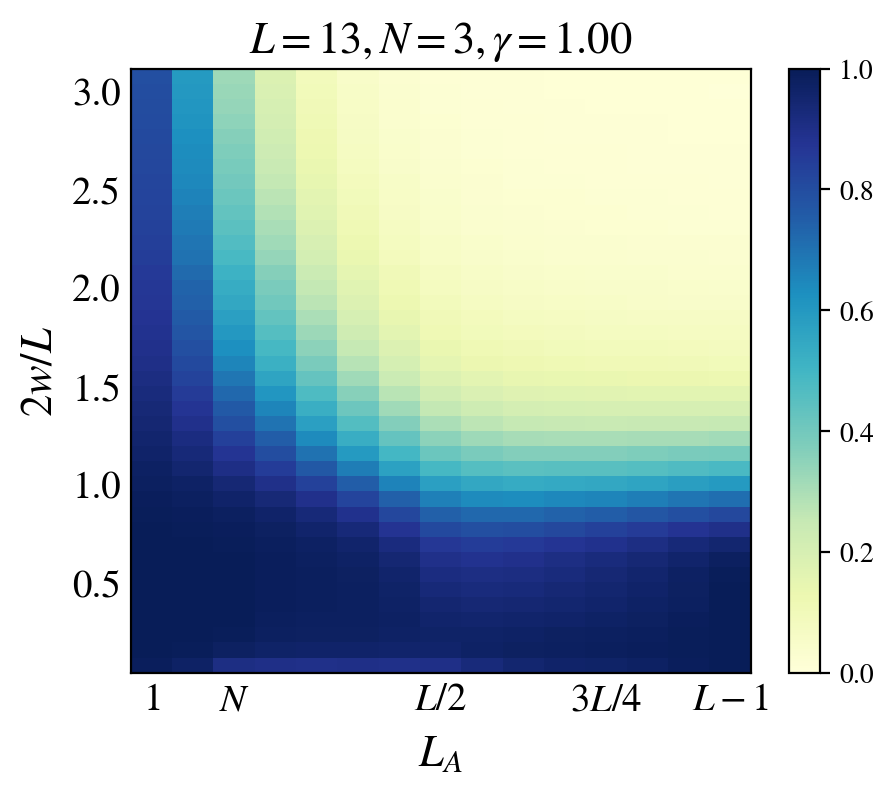

In [625]:

markers = itertools.cycle(markers_ls)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200)

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)
sub_sizes = np.arange(0, L_total+1)

density = np.zeros((sub_sizes.size, w_vals.size))

def frac(dim):
    return 200

for ii, w in enumerate(w_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            dim = energies.size
            num = frac(dim)

            E_av = np.mean(energies)
            index_meanE = min(range(dim), key=lambda i: abs(energies[i] - E_av))
            
            my_min = int(index_meanE - num / 2)
            if my_min < 0: my_min = 0;  

            my_max = int(index_meanE + num / 2) 
            if my_max >= dim: my_max = dim

            for LA in sub_sizes:
                S = np.array(file.get('entropies'))[LA]
                sample = S
                if my_min > 0 and my_max < dim:
                    sample = S[my_min : my_max]
                density[LA][ii] = np.mean(sample) / page(LA, L_total - LA)
    else:
        print(name)

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(sub_sizes, 2*w_vals / L)
print(X, Y)
p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, vmin=0, vmax=1.0)

axis.set_xlim(0.5, L_total-0.5)

fig_help.set_plot_elements(axis, ylabel=r"$2w/L$", xlabel=r"$L_A$", font_size=14, set_legend=False)

xticks = [1, N, L_total/2, 3*L_total/4, L_total-1]
tick_labels = ["$1$", "$N$", "$L/2$", "$3L/4$", "$L-1$"]
axis.set_xticks(xticks)
axis.set_xticklabels(tick_labels)


axis.set_title(r"$L=%d, N=%d, \gamma=%.2f$"%(L,N, gamma), fontsize=16)

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
fig.colorbar(p)
#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
 [ 0  1  2

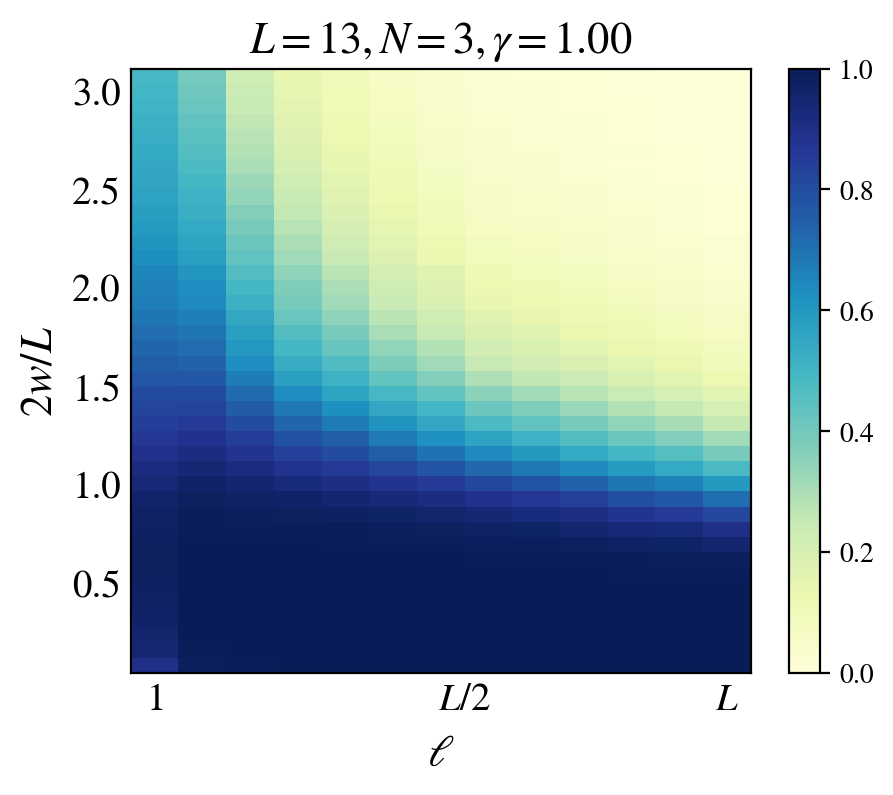

In [626]:

markers = itertools.cycle(markers_ls)

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,4), dpi = 200)

L_total=16
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

w_vals = np.linspace(0.5, 20., 40)
sub_sizes = np.arange(N, L_total+1)

density = np.zeros((sub_sizes.size, w_vals.size))

def frac(dim):
    return 200

for ii, w in enumerate(w_vals):
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            dim = energies.size
            num = frac(dim)

            E_av = np.mean(energies)
            index_meanE = min(range(dim), key=lambda i: abs(energies[i] - E_av))
            
            my_min = int(index_meanE - num / 2)
            if my_min < 0: my_min = 0;  

            my_max = int(index_meanE + num / 2) 
            if my_max >= dim: my_max = dim

            for ell in sub_sizes:
                S = np.array(file.get('single_site_entropy'))[ell]
                sample = S
                if my_min > 0 and my_max < dim:
                    sample = S[my_min : my_max]
                density[ell - N][ii] = np.mean(sample) / page(1, L_total - 1)
    else:
        print(name)

#white = plt.get_cmap('seismic', 100)(0.5*np.ones(1))
upper = plt.get_cmap('YlGnBu', 100)(np.linspace(0.0, 1.0, 100))
colors = np.vstack((upper))  

mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

X, Y = np.meshgrid(sub_sizes - N, 2*w_vals / L)
print(X, Y)
p = axis.pcolormesh(X, Y, np.transpose(density), shading='nearest', cmap=mymap, vmin=0, vmax=1.0)

axis.set_xlim(-0.5, L-0.5)

fig_help.set_plot_elements(axis, ylabel=r"$2w/L$", xlabel=r"$\ell$", font_size=14, set_legend=False)

xticks = [0, L/2, L-1]
tick_labels = ["$1$", "$L/2$", "$L$"]
axis.set_xticks(xticks)
axis.set_xticklabels(tick_labels)


axis.set_title(r"$L=%d, N=%d, \gamma=%.2f$"%(L,N, gamma), fontsize=16)

# axis.xaxis.set_minor_locator(plt.NullLocator())
# axis.yaxis.set_minor_locator(plt.NullLocator())
fig.colorbar(p)
#legend = axis.legend(frameon=1, fontsize=14, loc='upper left', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(0.0,1.0), facecolor="gray")
plt.show()

## GOE MATRIX

In [591]:

def partition_function(E, beta):
    return np.sum(np.exp(-beta * (E)))

def mean_energy(E, beta):
    return np.sum(E * np.exp(-beta * (E - E[0]))) / np.sum(np.exp(-beta * (E - E[0])))

def square_energy(E, beta):
    return np.sum(E**2 * np.exp(-beta * (E - E[0]))) / np.sum(np.exp(-beta * (E - E[0])))

def heat_capacity(E, beta):
    return (square_energy(E, beta) - mean_energy(E, beta)**2) * beta**2 / np.log2(E.size)

def thermal_entropy(E, beta):
    return (np.log(partition_function(E, beta)) + (mean_energy(E, beta) - E[0]) * beta) / np.log2(E.size)



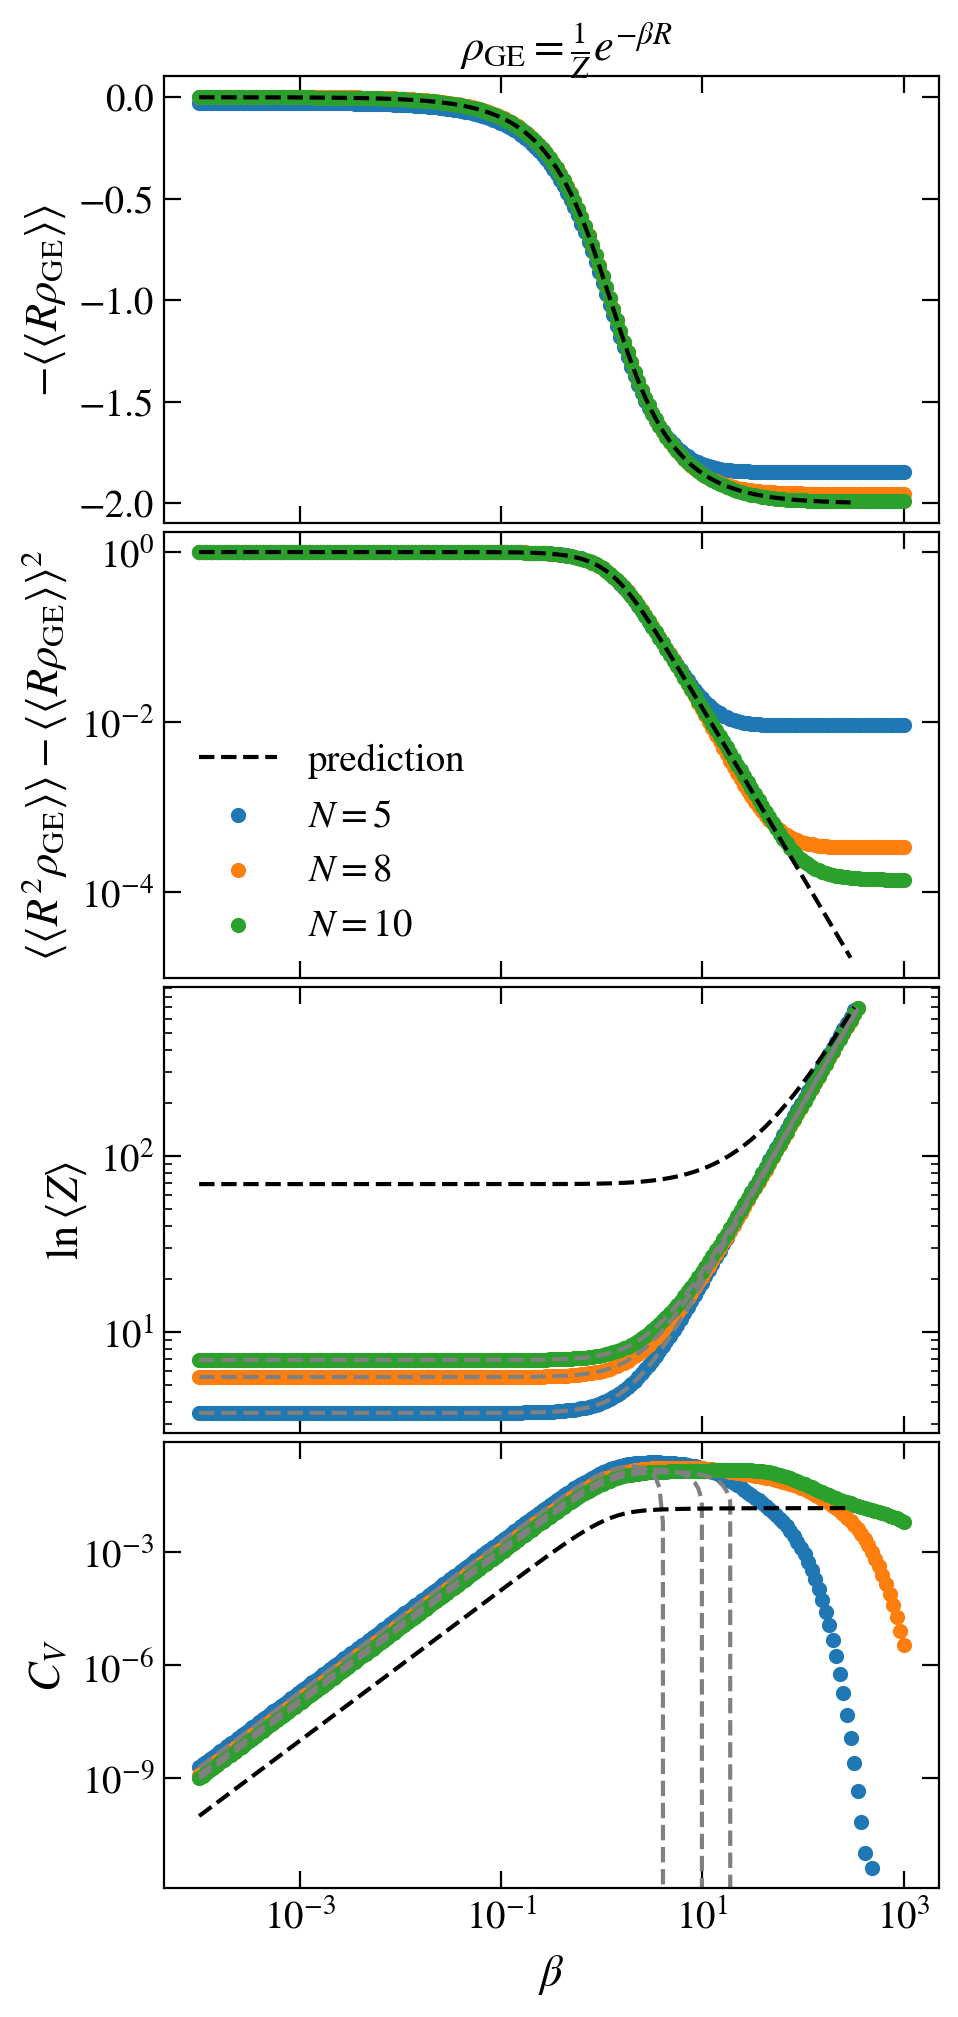

In [592]:
# N = 5
fig, axis = plt.subplots( nrows=4, ncols=1, figsize=(5,12), dpi = 200, sharex=True)

betas = np.logspace(-4, 3, 200)

for N in [5, 8, 10]:
    real = 10#200 - N**2
    Z = np.zeros((betas.size))
    E_av = np.zeros((betas.size))
    E2_av = np.zeros((betas.size))
    Cv = np.zeros((betas.size))
    for _ in range(real):
        E = goe.eigs(N)
        Z += np.array([partition_function(E, beta) for beta in betas]) / real
        E_av_tmp = np.array([mean_energy(E, beta) for beta in betas])
        E_av2_tmp = np.array([square_energy(E, beta) for beta in betas])

        Cv += (E_av2_tmp - E_av_tmp**2) * betas**2 / np.log2(E.size) / real
        E_av += (E_av_tmp / real)
        E2_av += E_av2_tmp / real
        # axis.plot(betas, np.abs(np.array([square_energy(E, beta) for beta in betas]) - prediction(betas, N)), label=r"$D=%d$"%E.size)
    axis[0].scatter(betas, E_av, label=r"$N=%d$"%N, s=20)
    axis[1].scatter(betas, E2_av-E_av**2, label=r"$N=%d$"%N, s=20)
    axis[2].scatter(betas, np.log(Z), label=r"$N=%d$"%N, s=20)
    axis[3].scatter(betas, Cv, label=r"$N=%d$"%N, s=20)
    
    axis[2].plot(betas, np.log(goe.partition_function(np.sqrt(2**(N) /(2**N + 1)) * betas, N)), color='gray', ls='--')
    axis[3].plot(betas, (goe.heat_capacity(np.sqrt(2**(N) /(2**N + 1)) * betas, N)), color='gray', ls='--')

N=100
axis[0].plot(betas, goe.energy_mean(np.sqrt(2**(N) /(2**N + 1)) * betas, N), color='black', ls='--')
axis[1].plot(betas, (goe.energy_variance(np.sqrt(2**(N) /(2**N + 1)) * betas, N) - prediction_mean_energy(np.sqrt(2**(N) /(2**N + 1)) * betas, N)**2), color='black', ls='--')
#axis.plot(betas, prediction_Z(np.sqrt(2**(2*N) /(2**N+1)) * betas, N), color='black', ls='--')
axis[2].plot(betas, np.log(goe.partition_function(np.sqrt(2**(N) /(2**N + 1)) * betas, N)), color='black', ls='--')
axis[3].plot(betas, (goe.heat_capacity(np.sqrt(2**(N) /(2**N + 1)) * betas, N)), color='black', ls='--')

axis[1].plot(np.nan, np.nan, color='black', ls='--', label='prediction')

#fig_help.set_plot_elements(axis, ylabel=r"$|\langle R^2\rho_{GE}\rangle-Y_N(\beta)|$", xlabel=r"$\beta$", font_size=14, set_legend=True, xscale='log', yscale='log')
axis[0].set_title(r"$\quad\rho_{\rm GE}=\frac{1}{Z}e^{-\beta R}$", fontsize=16)
fig_help.set_plot_elements(axis[0], ylabel=r"$-\langle\langle R\rho_{\rm GE}\rangle\rangle$", xlabel=r"", font_size=14, set_legend=False, xscale='log', yscale='linear')
fig_help.set_plot_elements(axis[1], ylabel=r"$\langle\langle R^2\rho_{\rm GE}\rangle\rangle-\langle\langle R\rho_{\rm GE}\rangle\rangle^2$", xlabel=r"", font_size=14, set_legend=True, xscale='log', yscale='log')
fig_help.set_plot_elements(axis[2], ylabel=r"$\ln\langle Z\rangle$", xlabel=r"$\beta$", font_size=14, set_legend=False, xscale='log', yscale='log')
fig_help.set_plot_elements(axis[3], ylabel=r"$C_V$", xlabel=r"$\beta$", font_size=14, set_legend=False, xscale='log', yscale='log')

fig.subplots_adjust(wspace = 0.02, hspace=0.02)

## BANDWIDTH COMPETITION

## DISTRIBUTIONS

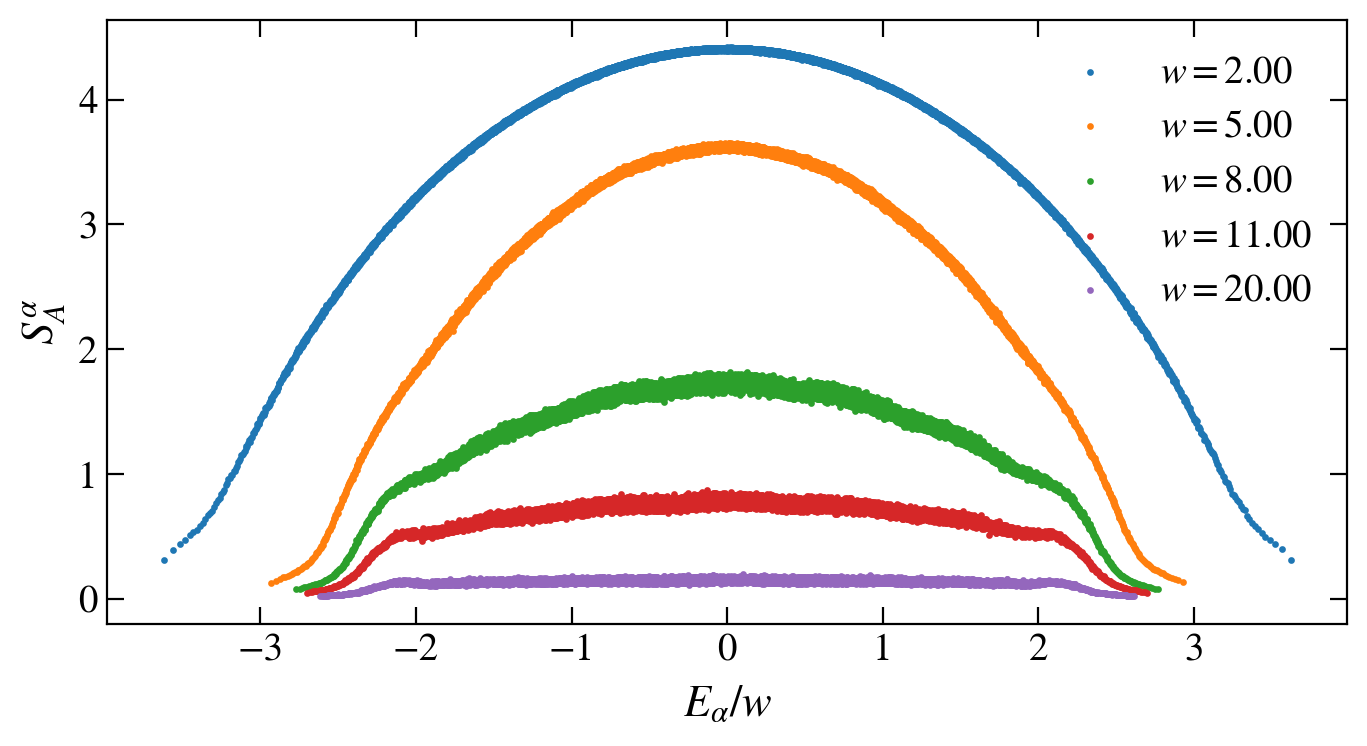

In [46]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,4), dpi = 200)

L_total=15
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=5
gamma=1.0
ini_ave=0
L = L_total - N
LA = L_total//2

for w in [2.0, 5.0, 8.0, 11.0, 20.0]:
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            entropies = np.array(file.get('entropies'))[L_total - LA]
            axis.scatter(energies / w, entropies, s=2, label=r"$w=%.2f$"%w)
    else:
        print(name)


fig_help.set_plot_elements(axis, ylabel=r"$S_A^\alpha$", xlabel=r"$E_\alpha/w$", font_size=14, set_legend=True)

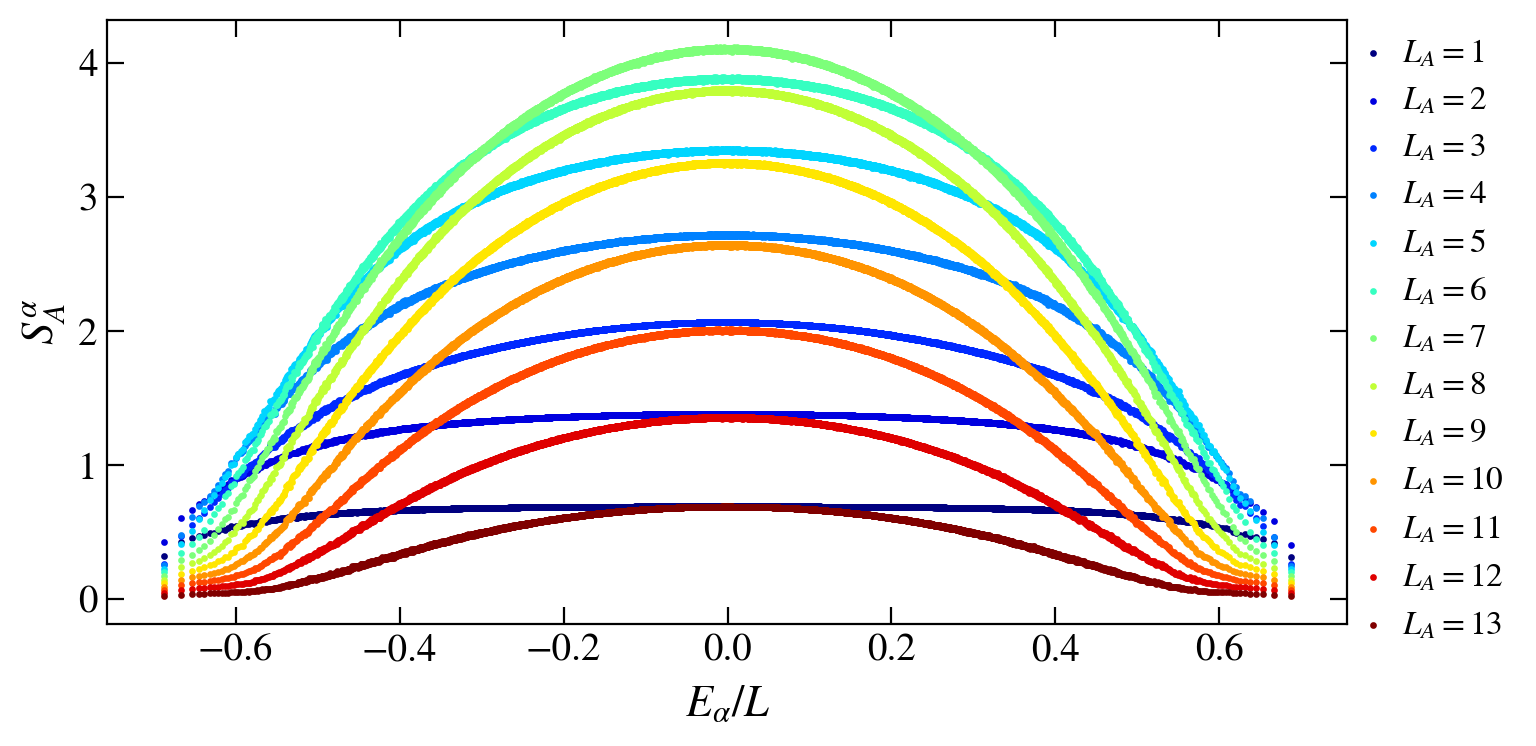

In [89]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,4), dpi = 200)

L_total=14
J=1.0
alfa=1.0
h=0.0
w=2.0
zeta=0.0
N=3
gamma=1.0
ini_ave=0
L = L_total - N

colors = plt.cm.jet(np.linspace(0, 1, L_total - 1))
for LA in np.arange(1, L_total):
    
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            
            entropies = np.array(file.get('entropies'))[LA]
            axis.scatter(energies / L, entropies, s=2, label=r"$L_A=%.d$"%LA, color=colors[LA-1])
    else:
        print(name)


fig_help.set_plot_elements(axis, ylabel=r"$S_A^\alpha$", xlabel=r"$E_\alpha/L$", font_size=14, set_legend=False)
axis.legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.15,1.02))

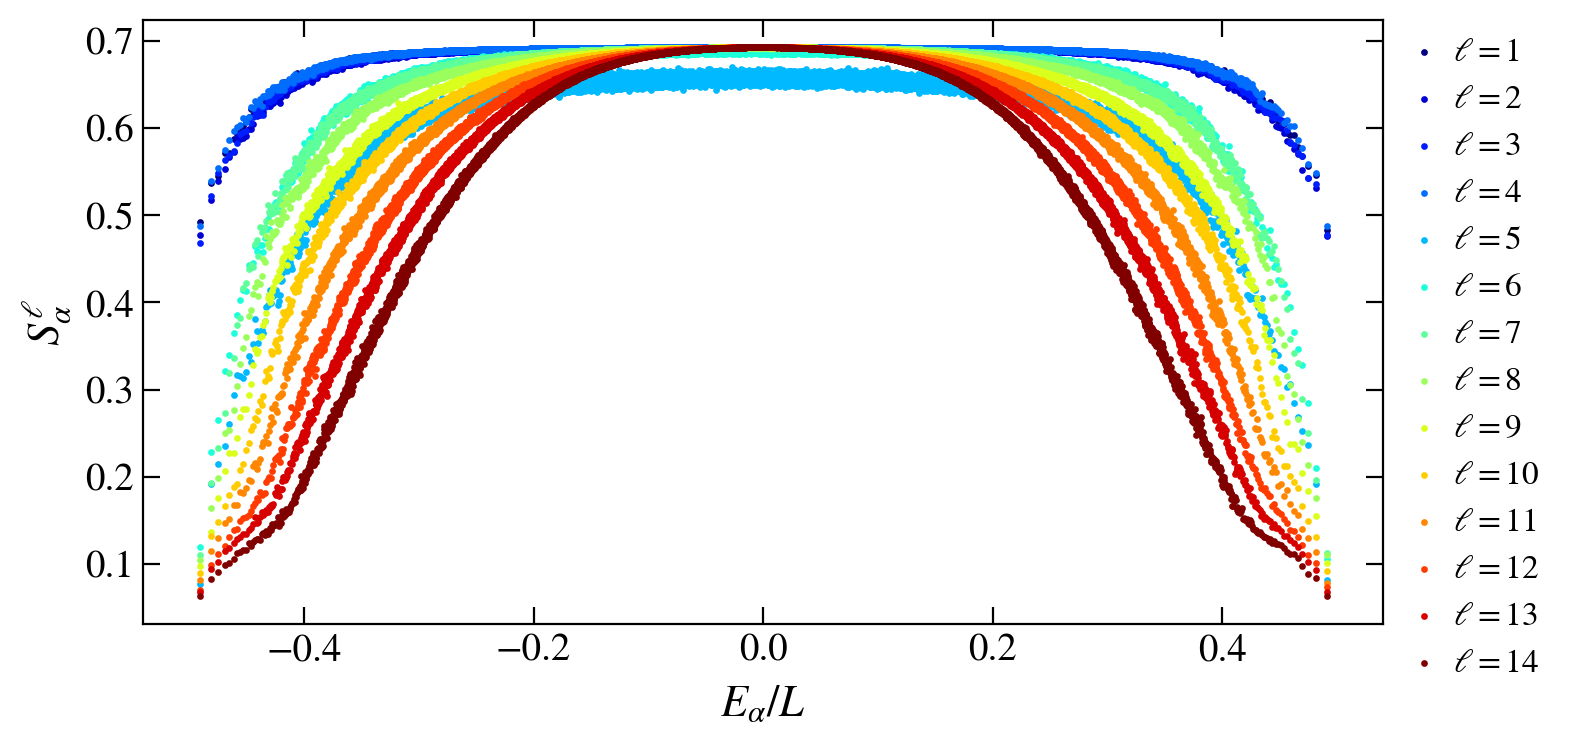

In [92]:

fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(8,4), dpi = 200)

L_total=15
J=1.0
alfa=1.0
h=0.0
w=1.0
zeta=0.0
N=5
gamma=1.0
ini_ave=0
L = L_total - N

colors = plt.cm.jet(np.linspace(0, 1, L_total - 1))
for LA in np.arange(1, L_total):
    
    name = base_dir + 'Entropy/Eigenstate/' + info(L=L, N=N, J=J, gamma=gamma, zeta=zeta, alfa=alfa, h=h, w=w, ext='.hdf5')
    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('mean energies'))
            
            entropies = np.array(file.get('single_site_entropy'))[LA]
            axis.scatter(energies / L, entropies, s=2, label=r"$\ell=%.d$"%LA, color=colors[LA-1])
    else:
        print(name)


fig_help.set_plot_elements(axis, ylabel=r"$S^\ell_\alpha$", xlabel=r"$E_\alpha/L$", font_size=14, set_legend=False)
axis.legend(loc = 'upper right', columnspacing=0.4, frameon=False, fontsize=12, handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.15,1.02))

### ELSE